# Идентификация интернет-пользователей. Отчёт

In [ ]:
# !unzip data.zip

## Содержание

1. [Цели и задачи проекта](#Цели-и-задачи-проекта)
2. [Постановка задачи](#Постановка-задачи)
2. описание исходных и обработанных данных и признаков.
2. первичный анализ признаков
3. первичный визуальный анализ признаков
4. если пришли к каким-то "инсайтам", обнаружили закономерности – изложите
5. описание предобработки данных
6. если создаются признаки, то описание этого процесса
7. кросс-валидация, построение кривых валидации и обучения
8. оценка модели с описанием выбранной метрики. Опишите простыми словами
9. качество модели, как она может применяться
10. выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. 
11. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

## Цели и задачи проекта

Постулируем 2 основные цели проекта:
- учебная
- исследовательская

К учебной части отнесём закрепление теоретических знаний и отработка их на парктике, а именно.

К исследовательской части отнесём следующие задачи:
- постановка ML-задачи
- предобработка входных данных
- exploratory data analysis (визулизация)
- feature engineering
- подбор модели и её гиперпараметров
- проверка модели на кроссвалидации и отложенных выборках
- оценка применения модели к бизнес-задачам

## Описание проекта

В проекте ставится задача по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком идентифицировать этого человека. Идея в том что, пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

## Описание входных данных

Входные данные взяты из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data".

Данные пришли с прокси-серверов Университета Блеза Паскаля и имеют следующий вид: для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в двух колонках: _timestamp, site_

Данные устроены следующем образом:

- каталог 3users – пример из 3 файлов для отладки кода предобработки
- в каталог 10users лежат 10 csv-файлов с названием вида "user[USER_ID].csv", где [USER_ID] – ID пользователя
- аналогично для каталога 150users – 150 пользователей

In [1]:
import os
import pandas as pd

PATH_TO_DATA = 'data'

Посмотрим на данные.

Пользователь 0001 из каталога с 3 пользователями:

In [4]:
pd.read_csv(os.path.join(PATH_TO_DATA, '3users/user0001.csv'))

,timestamp,site
0,2013-11-15 09:28:17,vk.com
1,2013-11-15 09:33:04,oracle.com
2,2013-11-15 09:52:48,oracle.com
3,2013-11-15 11:37:26,geo.mozilla.org
4,2013-11-15 11:40:32,oracle.com
5,2013-11-15 11:40:34,google.com
6,2013-11-15 11:40:35,accounts.google.com
7,2013-11-15 11:40:37,mail.google.com
8,2013-11-15 11:40:40,apis.google.com
9,2013-11-15 11:41:35,plus.google.com


Пользователь 0031 из каталога с 10 пользователями:

In [5]:
pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net
...,...,...
7595,2014-03-28 13:09:06,webmail.laposte.net
7596,2014-03-28 13:09:07,av.mediapostcommunication.net
7597,2014-03-28 13:09:07,www.google.com
7598,2014-03-28 13:09:07,webmail.laposte.net


Пользователь 0006 из каталога с 150 пользователями:

In [6]:
pd.read_csv(os.path.join(PATH_TO_DATA, '150users/user0006.csv'))

,timestamp,site
0,2013-11-15 08:01:09,www.google.fr
1,2013-11-15 08:01:10,www.google.fr
2,2013-11-15 08:01:11,apis.google.com
3,2013-11-15 08:01:12,www.google.com
4,2013-11-15 08:01:16,www.google.fr
...,...,...
21360,2014-05-28 19:10:00,www.facebook.com
21361,2014-05-28 19:10:01,i3.mangareader.net
21362,2014-05-28 19:10:14,www.mangareader.net
21363,2014-05-28 19:10:15,www.facebook.com


## Постановка задачи

Для достижения целей проекта поставим ML-задачу: 
- классификация
- объект: сессия
- целевой признак: id пользователя

Сессия - последовательность n-посещенных сайтов. Размер сессий определяется:
- количеством сайтом
- временем от первого сайта в сессии

Таким образом требуется преобразовать входные данные в вид:

|site1|timestamp1|site2|timestamp2|...|site_n|timestamp_n|user_id|
|---|---|---|---|---|---|---|---|

То есть для каждого пользователя его история посещения разбивается на окна размера $n$ с шагом $m$ ($n$ и $m$ - параметры)

Возможны варианты классификации:
- многоклассовая (целевой признак user_id)
- бинарная классификация (один из пользователей объявляется искомым; для этого пользователя целевой признак принимает значение True, для остальных - False)

## Подготовка обучающей выборки

In [9]:
import itertools
from itertools import islice
from itertools import tee

from glob import glob
import pickle
import numpy as np
import pandas as pd
import os

from scipy.sparse import csr_matrix

from tqdm.notebook import tqdm

PATH_TO_DATA = 'data'

Создадим словари сайтов в формате:

`{'site_string': [site_id, site_freq]}`

Разобьём данные по сессиям с параметром длины сессии (10 сайтов)

In [4]:
def prepare_train_set(path_to_csv_files, session_length=10):
    site_dict = {} # словарь для задания
    site_map = {0: 0} # удобный словарь для маппинга сайтов в айдишники
    train_set = []
    user_ids = [] # user_id сохраняем в отдельный список, потом удобно его вставить в датафрейм
    site_id = 1
    for file in tqdm(glob(path_to_csv_files + '/*')):
        user_id = int(os.path.splitext(os.path.basename(file))[0][-4:])
        with open(file) as reader:
            reader.readline() # пропускаем первую строку
            # читаем батчами по session_length строк
            for batch in iter(lambda: tuple(islice(reader, session_length)), ()):
                sites = list(map(lambda x: x.split(',')[1].strip(), batch))
                # обновляем словари
                for site in sites:
                    if site not in site_dict:
                        site_map[site] = site_id
                        site_dict[site] = (site_id, 1)
                        site_id += 1
                    else:
                        t = site_dict[site]
                        site_dict[site] = (t[0], t[1] + 1)
                user_ids.append(user_id)
                train_set.append(sites)
    train_set = pd.DataFrame(train_set, columns=[f'site{i+1}' for i in range(session_length)]).fillna(0)
    train_set = train_set.applymap(lambda x: site_map[x] if type(x)==str else x)
    train_set['user_id'] = user_ids
    return train_set, site_dict

In [10]:
%%time
train_data_toy, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, '3users'))
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'))
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 4.23 s, sys: 176 ms, total: 4.41 s
Wall time: 4.45 s


In [11]:
site_freq_3users

{'accounts.google.com': (5, 1),
 'apis.google.com': (7, 1),
 'football.kulichki.ru': (9, 2),
 'geo.mozilla.org': (3, 1),
 'google.com': (4, 9),
 'mail.google.com': (6, 2),
 'meduza.io': (10, 3),
 'oracle.com': (2, 8),
 'plus.google.com': (8, 1),
 'vk.com': (1, 3),
 'yandex.ru': (11, 1)}

In [12]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,1,2,2,3,2,4,5,6,7,8,1
1,1,4,4,4,0,0,0,0,0,0,1
2,1,2,9,9,2,0,0,0,0,0,2
3,10,4,2,4,2,4,4,6,11,10,3
4,10,4,2,0,0,0,0,0,0,0,3


Сохраним полученные датасеты в csv-формате,а словари в pickle-формате.

In [13]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), index_label='session_id', float_format='%d')
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_3users.pkl'), 'wb') as site_freq_3users_pkl:
    pickle.dump(site_freq_3users, site_freq_3users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

Разобъём данные на сессии с использованием концепции "мешка слов". Размер сессии и шаг параметризируем.

"Мешок слов" - матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$.

In [14]:
def get_session(session_it, session_length):
    '''
    Принимает итератор
    Возвращает список посещений заданной длины сессии
    '''
    try:
        for i in range(session_length):
            yield next(session_it)
    except StopIteration:
        return

In [15]:
def get_sites(file, session_length, window_size):
    '''
    Создаёт массив сессий пользователя
    session_length: длины сессии
    window_size: длина шага
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # копируем итератор в новый; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(get_session(session_it, session_length))
                if session:
                    yield list(map(lambda x: x.split(',')[1].strip(), session))
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [16]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    '''
    Аргументы:
    path_to_csv_files: путь к каталогу с csv-файлами
    site_freq_path: путь к pickle-файлу с частотным словарем
    session_length: длина сессии (параметр)
    window_size: ширина окна (параметр)

    Возвращает:
    X_sparse: двухмерная разреженная матрица Scipy.sparse.csr_matrix, в которой строки соответствуют сессиям из session_length сайтов, 
    а max(site_id) столбцов – количеству посещений site_id в сессии
    y: целевой признак, вектор (Numpy array) ID пользователей, которым принадлежат сессии из X_sparse
    '''
    site_dict = []
    train_set, user_ids = [], []

    # скачиваем словарь сайтов    
    with open(site_freq_path, 'rb') as f:
        site_dict.append(pickle.load(f))
    site_map = {k: v[0] for k, v in site_dict[0].items()}

    
    for file_ in tqdm(glob(os.path.join(path_to_csv_files, '*'))):
        user_id = int(os.path.splitext(os.path.basename(file_))[0][-4:])
        with open(file_) as f:
            f.readline() # пропускаем первую строку
            # итерируемся по сессиям одного пользователя
            for session in get_sites(f, session_length, window_size):
                train_set.append(session)
                user_ids.append(user_id)
                
    train_set = pd.DataFrame(train_set).fillna(0)
    train_set.columns = [f'site{i+1}' for i in range(train_set.columns.size)] # если максимальная длина сессии меньше session_length
    train_set = train_set.applymap(lambda x: site_map[x] if type(x)==str else x).values
    
    # создаём bag of sites
    data = [1] * train_set.size # массив единиц длины n*m - count'ы сайтов (с повторениями)
    indices = train_set.flatten() # массив индексов столбцоы, на которых размещаются единицы; по сути спрямлённый DataFrame индексов
    indptr = list(range(0, train_set.size + 1, session_length)) # массив отрезков длины сессии (в нашем случае просто отсечки по длинам строк)
    X_sparse = csr_matrix((data, indices, indptr))[:, 1:] # отрезаем столбец для сайта 0 (отсутствие посещения)

    return X_sparse, np.array(user_ids)

Для параметров возьмём значения:
- размер сессии: 5, 7, 10, 15
- размер шага окна: 5, 7, 10

Сохраним полученные csr-матрицы и векторы целевых признаков в сериализованном виде.

In [17]:
%%time
data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, f'{num_users}users'), 
                                                          os.path.join(PATH_TO_DATA, 'site_freqs', f'site_freq_{num_users}users.pkl'),
                                                          session_length=session_length, window_size=window_size)
            with open(os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl'), 'wb')\
                                                                                                                as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 'sparse_features', f'y_{num_users}users_s{session_length}_w{window_size}.pkl'), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)
            data_lengths.append(X_sparse.shape[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 55.7 s, sys: 1.62 s, total: 57.3 s
Wall time: 57.6 s


## Exploratory Data Analysis

### Первичный анализ

Исследуем данные, посмотрим на распределения, построим визуализации. Далее создадим новые признаки, проведём их исследование.

In [25]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import stats
from statsmodels.stats.proportion import proportion_confint

import warnings
warnings.filterwarnings('ignore')

PATH_TO_DATA = 'data'

In [2]:
site_freq_3users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_3users.pkl'))
site_freq_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_10users.pkl'))
site_freq_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_150users.pkl'))
train_data_10users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')
train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), 
                       index_col='session_id')

Количество уникальных сайтов:

In [3]:
print('для 3 пользователей:', len(site_freq_3users))
print('для 10 пользователей:', len(site_freq_10users))
print('для 150 пользователей:', len(site_freq_150users))

для 3 пользователей: 11
для 10 пользователей: 4913
для 150 пользователей: 27797


Топ-20 популярных сайтов для 10 пользователей:

In [4]:
sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:20]

[('s.youtube.com', (210, 8300)),
 ('www.google.fr', (51, 7813)),
 ('www.google.com', (4, 5441)),
 ('mail.google.com', (183, 4158)),
 ('www.facebook.com', (15, 4141)),
 ('apis.google.com', (52, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)),
 ('plus.google.com', (187, 2630)),
 ('accounts.google.com', (184, 2089)),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (699, 1939)),
 ('fr-mg42.mail.yahoo.com', (622, 1868)),
 ('www.youtube.com', (207, 1804)),
 ('r4---sn-gxo5uxg-jqbe.googlevideo.com', (208, 1702)),
 ('clients1.google.com', (568, 1493)),
 ('download.jboss.org', (1796, 1441)),
 ('s-static.ak.facebook.com', (66, 1388)),
 ('static.ak.facebook.com', (63, 1265)),
 ('i1.ytimg.com', (205, 1232)),
 ('twitter.com', (72, 1204))]

Топ-20 популярных сайтов для 150 пользователей:

In [5]:
sorted(site_freq_150users.items(), key=lambda x: x[1][1], reverse=True)[:20]

[('www.google.fr', (1, 64785)),
 ('www.google.com', (3, 51320)),
 ('www.facebook.com', (41, 39002)),
 ('apis.google.com', (2, 29983)),
 ('s.youtube.com', (181, 29102)),
 ('clients1.google.com', (214, 25087)),
 ('mail.google.com', (28, 19072)),
 ('plus.google.com', (27, 18467)),
 ('safebrowsing-cache.google.com', (293, 17960)),
 ('www.youtube.com', (105, 16319)),
 ('twitter.com', (44, 16219)),
 ('platform.twitter.com', (37, 15317)),
 ('s-static.ak.facebook.com', (43, 15048)),
 ('accounts.google.com', (24, 13855)),
 ('www.bing.com', (202, 13797)),
 ('static.ak.facebook.com', (42, 13117)),
 ('i1.ytimg.com', (107, 13117)),
 ('download.jboss.org', (3537, 11740)),
 ('api.twitter.com', (3398, 9350)),
 ('safebrowsing.clients.google.com', (292, 8981))]

Посмотрим на данные по 10 пользователям (сессия: длина 10, шаг 10)

In [6]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,1,2,3,4,3,3,4,3,5,3,31
1,6,7,8,9,3,10,11,12,13,14,31
2,14,4,14,14,15,16,6,17,18,14,31
3,19,20,19,14,14,14,14,21,22,23,31
4,24,14,15,25,26,27,28,29,30,29,31
...,...,...,...,...,...,...,...,...,...,...,...
14056,4,183,52,184,51,185,4,52,186,3585,241
14057,184,185,3585,186,188,4,183,187,183,188,241
14058,189,183,187,52,184,615,187,189,183,183,241


In [7]:
train_data_10users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


Распределение целевого признака:

In [8]:
train_data_10users['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов

In [9]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]

In [10]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

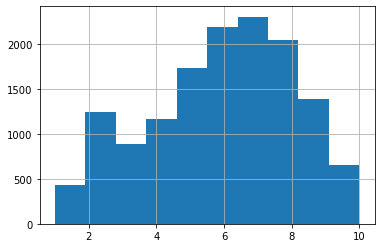

In [11]:
pd.Series(num_unique_sites).hist();

Проверим с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально

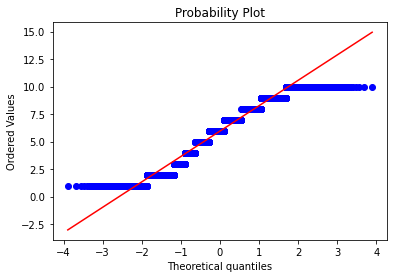

In [12]:
stats.probplot(num_unique_sites, plot=plt);

In [26]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites))

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


Гипотезу о нормальности распределения отвергаем.

Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%.

In [14]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [15]:
# число успехов, число попыток
has_two_similar.sum(), has_two_similar.size

(13410, 14061)

In [16]:
# доля успехов
has_two_similar.sum() / has_two_similar.size

0.9537017281843396

H0: p = 0.95

H1: p > 0.95

In [17]:
pi_val = stats.binom_test(x=has_two_similar.sum(), n=has_two_similar.size, p=0.95, alternative='greater')
pi_val

0.02207653769072678

p-value меньше 0.05. Нулевую гипотезу отвергаем, вероятность повторения сайта в сессии значимо больше 95%

Построим для этой доли 95% доверительный интервал Уилсона

In [18]:
wilson_interval = proportion_confint(count=has_two_similar.sum(), nobs=has_two_similar.size, method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [19]:
site_freqs = train_data_10users.iloc[:, :-1].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)

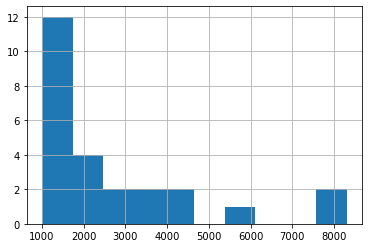

In [20]:
site_freqs[site_freqs >= 1000].hist();

Построим 95% доверительный интервал для средней частоты появления сайта в выборке на основе bootstrap. Используем столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям.

In [21]:
site_freqs.drop(0, inplace=True) # удаляем сайт с индексом 0

In [22]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [23]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [24]:
bootstrap_mean_scores = list(map(np.mean, get_bootstrap_samples(site_freqs.values, len(site_freqs))))
interval = stat_intervals(bootstrap_mean_scores, 0.05)

print("95% доверительный интервал для средних значений частот посещений сайтов:",  interval)

95% доверительный интервал для средних значений частот посещений сайтов: [22.51524527 35.76303684]


### Feature engineering

In [17]:
import os
from glob import glob
from itertools import tee

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

PATH_TO_DATA = 'data'

#### Создание признаков

Для увеличение точности предсказаний выделим из данных новые признаки.

Построим следующие признаки:
- Временнные
    - час начала сессии
        - утро
        - день
        - вечер
    - dummy часы
    - минута
    - час + минута
        - циклические координаты (sin, cos часа+минуты)
    - месяц
        - сезон
        - dummy месяцы
    - год
    - год + месяц
    - день недели
        - dummy дни недели
    - длина сессии
    - время посещения сайта (разница во времени между посещениями сайтов)
    - среднее время на сайте
- Сайты:
    - количество уникальных сайтов в сессии
    - факт посещения сайтов из топ-10 популярных сайтов

In [2]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    '''
    Преобразует набор файлов в датасет: строка - сессия
    '''
    
    train_set, user_ids = [], []

    # загружаем словарь сайтов
    site_dict = pd.read_pickle(site_freq_path)
    site_map = {k: v[0] for k, v in site_dict.items()}
    top10 = sorted(site_dict.items(), key=lambda x: x[1][1], reverse=True)[:10]
    top10_ids = [x[1][0] for x in top10]

    # выражаем
    for file_ in tqdm(glob(os.path.join(path_to_csv_files, '*'))): # '*'
        user_id = int(os.path.splitext(os.path.basename(file_))[0][-4:]) # берём user id из имени файла
        with open(file_) as f:
            f.readline() # пропускаем первую строку
            # итерируемся по сессиям одного пользователя
            for session in feature_engineering(f, session_length, window_size, site_map, user_id, top10_ids):
                train_set.append(session)
                user_ids.append(user_id)
                
    return pd.DataFrame(train_set, dtype='int', columns=feature_names)

In [3]:
def session_string(session_it, session_length):
    '''
    Генератор
    Принимает итератор по файлу
    Возвращает строку
    '''
    try:
        for i in range(session_length):
            yield next(session_it)
    except StopIteration:
        return

In [4]:
def feature_engineering(file, session_length, window_size, site_map, user_id, top10_ids):
    '''
    Генератор
    Создаёт признаки сессии:
    - Временные:
      - час начала сессии
        - утро
        - день
        - вечер
        - циклические координаты (sin, cos часа)
        - dummy часы
      - минута
      - час + минута
      - месяц
        - сезон
        - dummy месяцы
      - год
      - год + месяц
      - день недели
        - dummy дни недели
      - длина сессии
      - время посещения сайта (разница во времени между посещениями сайтов)
      - среднее время на сайте
    - Сайты:
      - количество уникальных сайтов в сессии
      - факт посещения сайтов из топ-10 популярных сайтов
    - user_id: целевой признак
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # разделяем итератор на два; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(session_string(session_it, session_length))
                if session: # чтобы не возвращать в конце пустую строку
                    # обрабатываем сайты
                    sites_fact = list(map(lambda x: x.split(',')[1].strip(), session))
                    sites_ids = np.array([site_map[site] for site in sites_fact])
                    # список сайтов
                    sites = np.zeros(session_length)
                    sites[:len(sites_fact)] = sites_ids

                    # число уникальных сайтов
                    n_unique_sites = np.unique(sites_ids).size
                    # факт посещения сайтов из топ-10 популярных сайтов
                    has_top10 = len(set(sites).intersection(set(top10_ids))) > 0
                    
                    # обрабатываем timestamp'ы
                    times_fact = list(map(lambda x: pd.to_datetime(x.split(',')[0].strip()), session))
                    timediffs = np.array([(times_fact[i+1] - times_fact[i]).seconds for i in range(len(times_fact) - 1)])
                    # список разниц времён - по сути время посещения каждого сайта (кроме последнего)
                    times = np.zeros(session_length - 1)
                    times[:len(timediffs)] = timediffs
                    # длина сессии (минус время посещения последнего сайта)
                    session_timespan = (times_fact[-1] - times_fact[0]).seconds
                    # час начала сессии
                    hour = times_fact[0].hour
                    # минута начала сессии
                    minute = times_fact[0].minute
                    # час + минута
                    hour_minute = hour + minute / 60
                    # циклические координаты
                    sin_hour_minute = np.sin(2*np.pi*hour_minute/24)
                    cos_hour_minute = np.cos(2*np.pi*hour_minute/24)
                    # секунда начала сессии
                    second = times_fact[0].second
                    # день недели начала сессии
                    day_of_week = times_fact[0].weekday()
                    # год начала сессии
                    year = times_fact[0].year
                    # месяц начала сессии
                    month = times_fact[0].month
                    # год + месяц
                    year_month = year + (month - 1) / 12
                    # день начала сессии
                    day = times_fact[0].day
                    # выходной (бинарный)
                    is_weekend = (day_of_week // 5 == 1)
                    # время суток
                    morning = (hour >= 7) & (hour <= 11)
                    midday = (hour >= 12) & (hour <= 18)
                    evening = (hour >= 19) & (hour <= 23)
                    night = (hour >= 0) & (hour <= 6)
                    # среднее время на сайте
                    visit_mean_time = timediffs.mean()
                                                            
                    yield np.concatenate(
                        (sites,
                         [n_unique_sites],
                         [has_top10],
                         times,
                         [session_timespan], 
                         [hour],
                         [minute],
                         [hour_minute],
                         [sin_hour_minute],
                         [cos_hour_minute],
                         [second],
                         [day_of_week], 
                         [year], 
                         [month],
                         [year_month],
                         [day], 
                         [is_weekend], 
                         [morning],
                         [midday],
                         [evening],
                         [night],
                         [visit_mean_time],
                         [user_id])
                    )
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [5]:
# проверка
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['n_unique_sites'] + \
                ['has_top10'] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', 
                 'hour',
                 'minute',
                 'hour_minute',
                 'sin_hour_minute',
                 'cos_hour_minute',
                 'second',
                 'day_of_week', 
                 'year', 
                 'month', 
                 'year_month',
                 'day', 
                 'is_weekend',
                 'morning',
                 'midday',
                 'evening',
                 'night',
                 'visit_mean_time', 
                 'user_id']
train_data_fe  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                                            site_freq_path=os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_3users.pkl'),
                                            feature_names=feature_names)
train_data_fe

  0%|          | 0/3 [00:00<?, ?it/s]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,month,year_month,day,is_weekend,morning,midday,evening,night,visit_mean_time,user_id
0,1,2,2,3,2,4,5,6,7,8,...,11,2013.833333,15,0,1,0,0,0,888.666667,1
1,1,4,4,4,0,0,0,0,0,0,...,11,2013.833333,15,0,0,1,0,0,20.000000,1
2,1,2,9,9,2,0,0,0,0,0,...,11,2013.833333,15,0,1,0,0,0,1983.750000,2
3,10,4,2,4,2,4,4,6,11,10,...,11,2013.833333,15,0,1,0,0,0,888.666667,3
4,10,4,2,0,0,0,0,0,0,0,...,11,2013.833333,15,0,0,1,0,0,735.500000,3


Выделим признаки из датасета с 10 пользователями с параметрами размер окна 10, размер шага 10

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_10users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 13.7 s, sys: 69.4 ms, total: 13.8 s
Wall time: 14 s


Выделим признаки из датасета с 150 пользователями с параметрами размер окна 10, размер шага 10

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_150users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 2min 11s, sys: 690 ms, total: 2min 12s
Wall time: 2min 15s


Сохраним новые признаки в picke-формате

In [12]:
train_data_10users.to_pickle(os.path.join(PATH_TO_DATA, 'new_features_10users_s10_w10.pkl'))
train_data_150users.to_pickle(os.path.join(PATH_TO_DATA, 'new_features_150users_s10_w10.pkl'))

#### Визуальный анализ данных

##### Год начала сессии

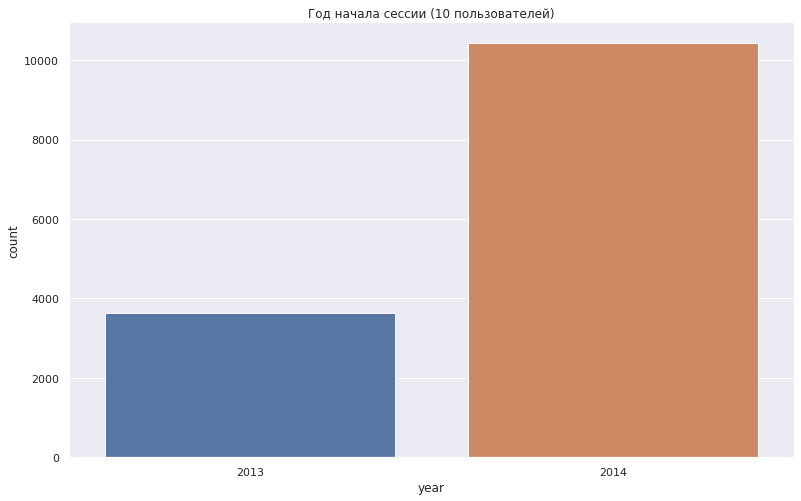

In [22]:
plt.title('Год начала сессии (10 пользователей)')
sns.countplot(train_data_10users.year);

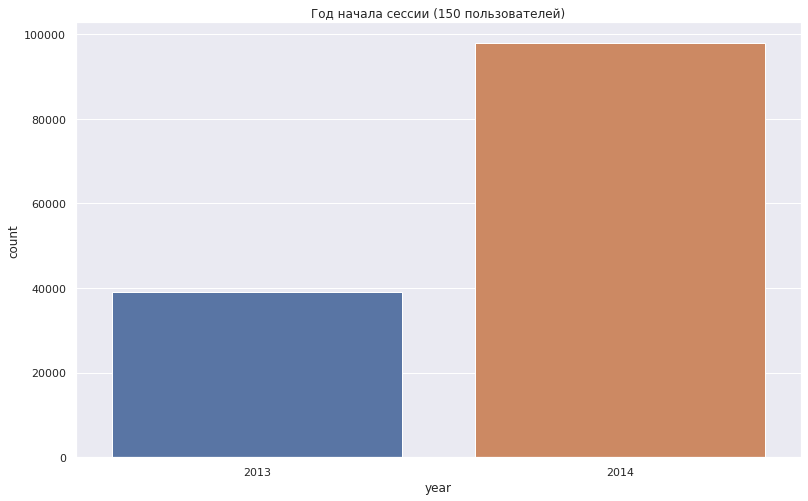

In [23]:
plt.title('Год начала сессии (150 пользователей)')
sns.countplot(train_data_150users.year);

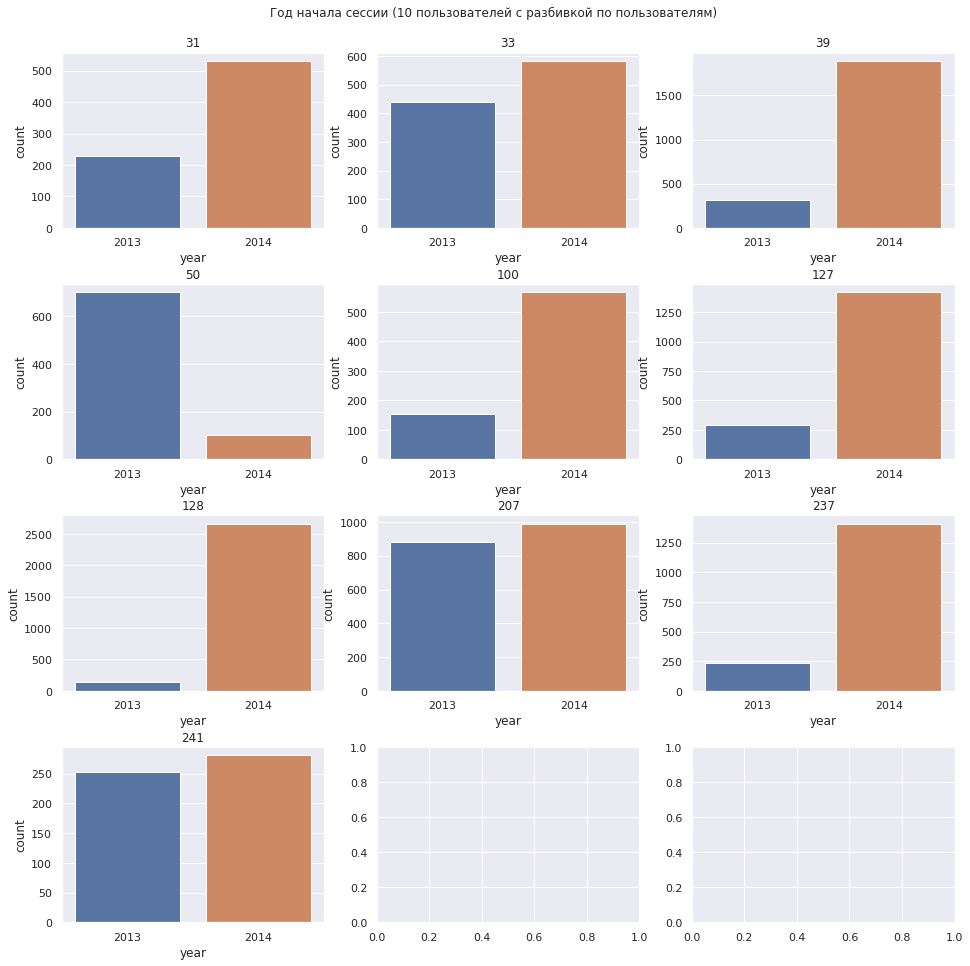

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Год начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.year, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Месяц начала сессии

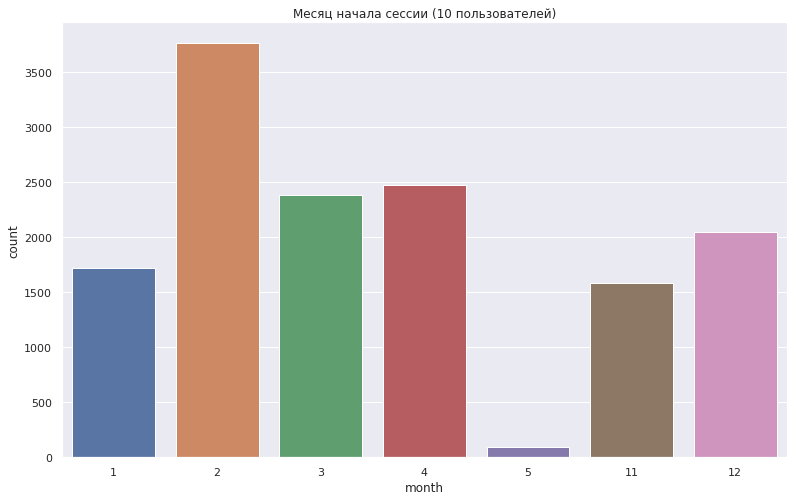

In [43]:
plt.title('Месяц начала сессии (10 пользователей)')
sns.countplot(train_data_10users.month);

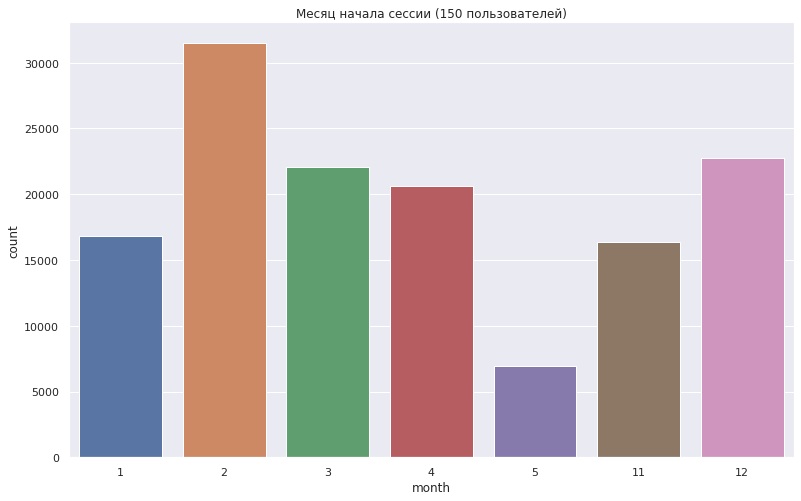

In [44]:
plt.title('Месяц начала сессии (150 пользователей)')
sns.countplot(train_data_150users.month);

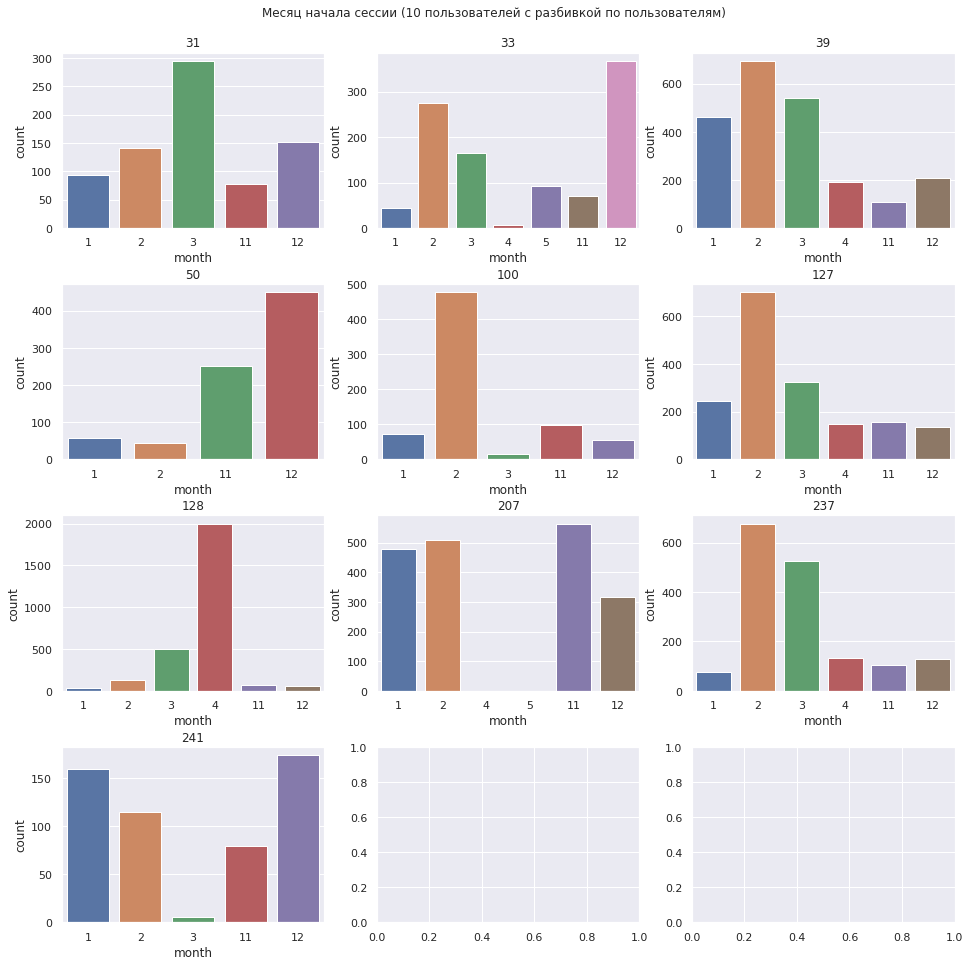

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Месяц начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.month, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Год+месяц

In [46]:
train_data_10users.year_month = train_data_10users.year_month.round(2)
train_data_150users.year_month = train_data_150users.year_month.round(2)

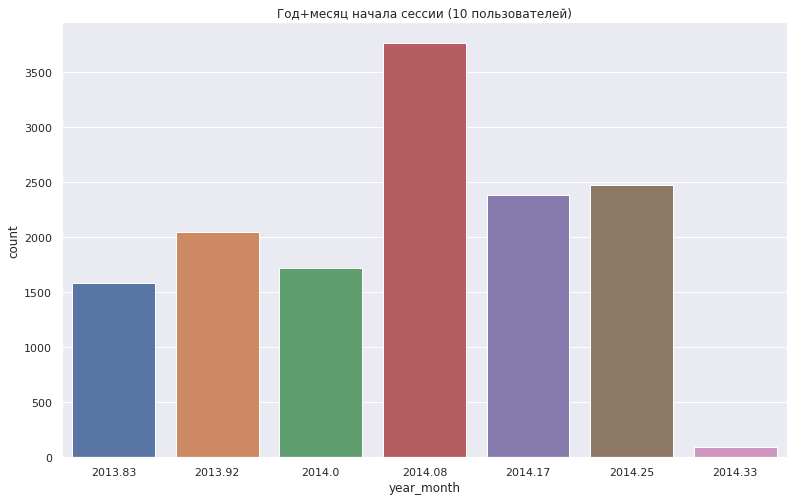

In [47]:
plt.title('Год+месяц начала сессии (10 пользователей)')
sns.countplot(train_data_10users.year_month);

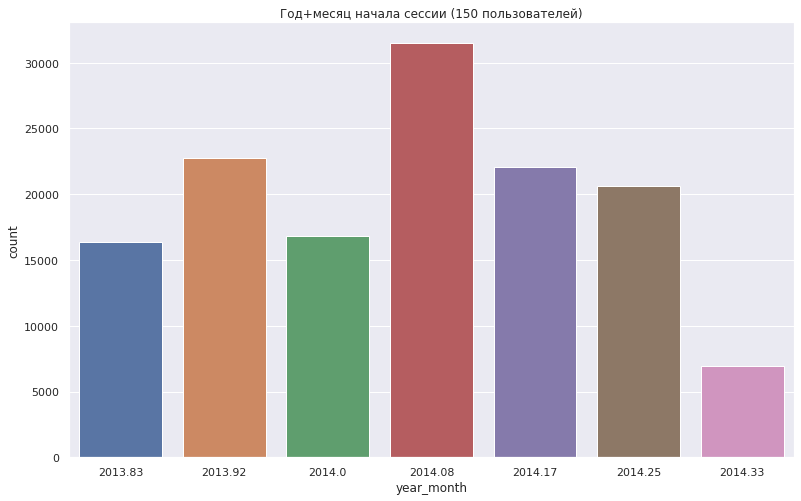

In [48]:
plt.title('Год+месяц начала сессии (150 пользователей)')
sns.countplot(train_data_150users.year_month);

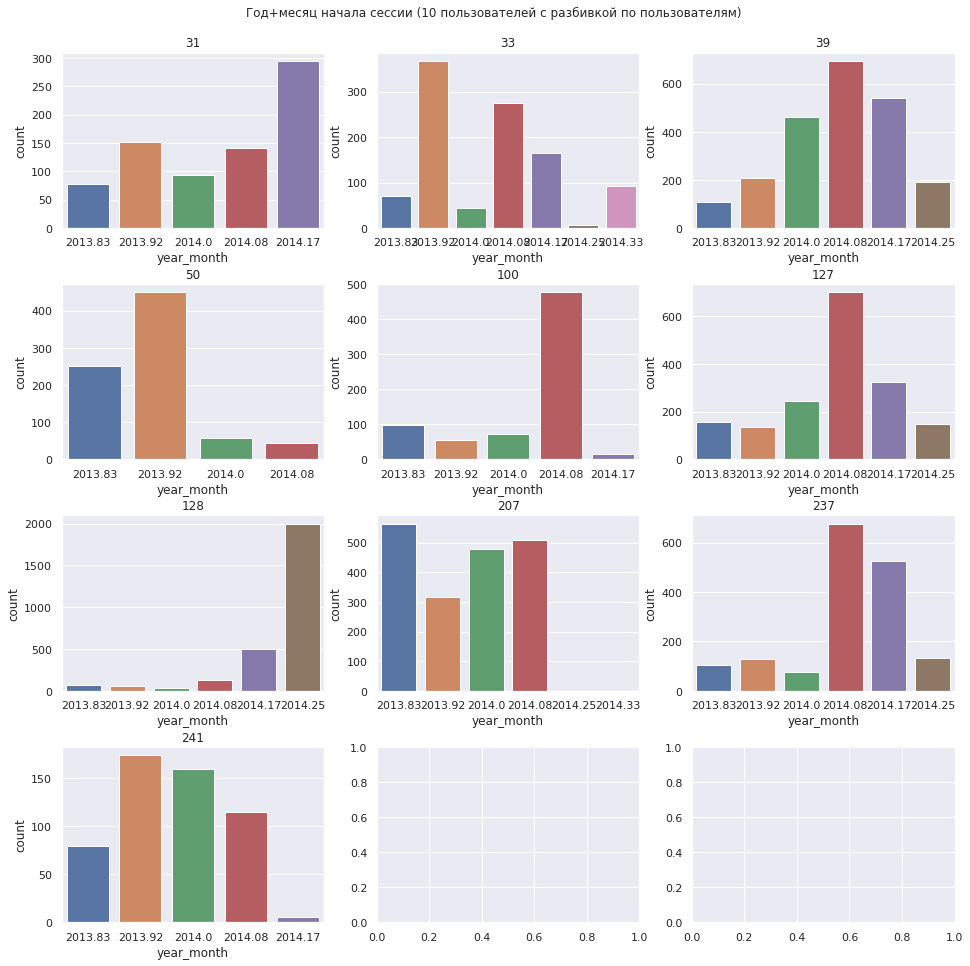

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Год+месяц начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.year_month, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### День начала сессии

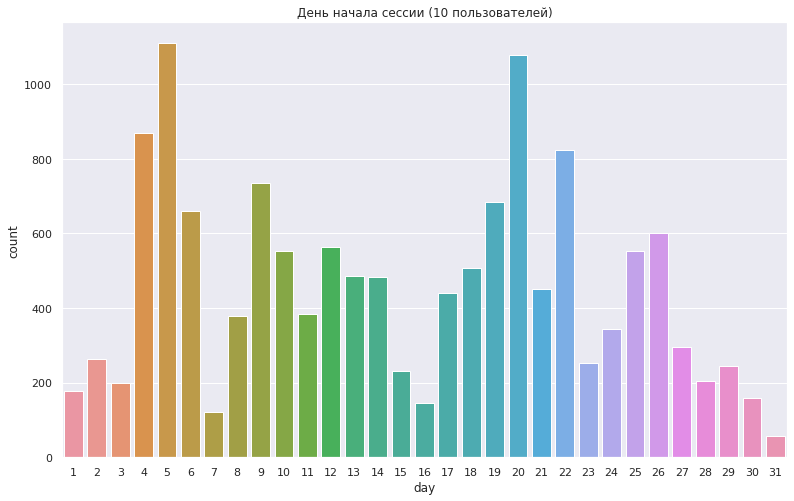

In [52]:
sns.countplot(train_data_10users.day)
plt.title('День начала сессии (10 пользователей)');

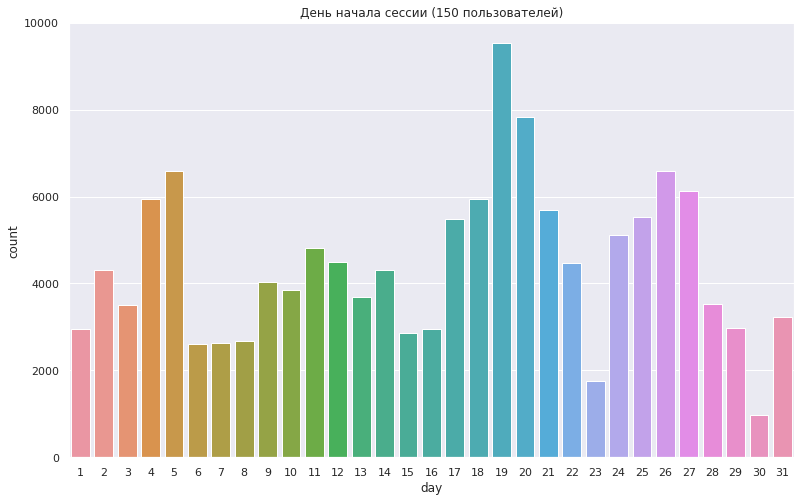

In [53]:
sns.countplot(train_data_150users.day)
plt.title('День начала сессии (150 пользователей)');

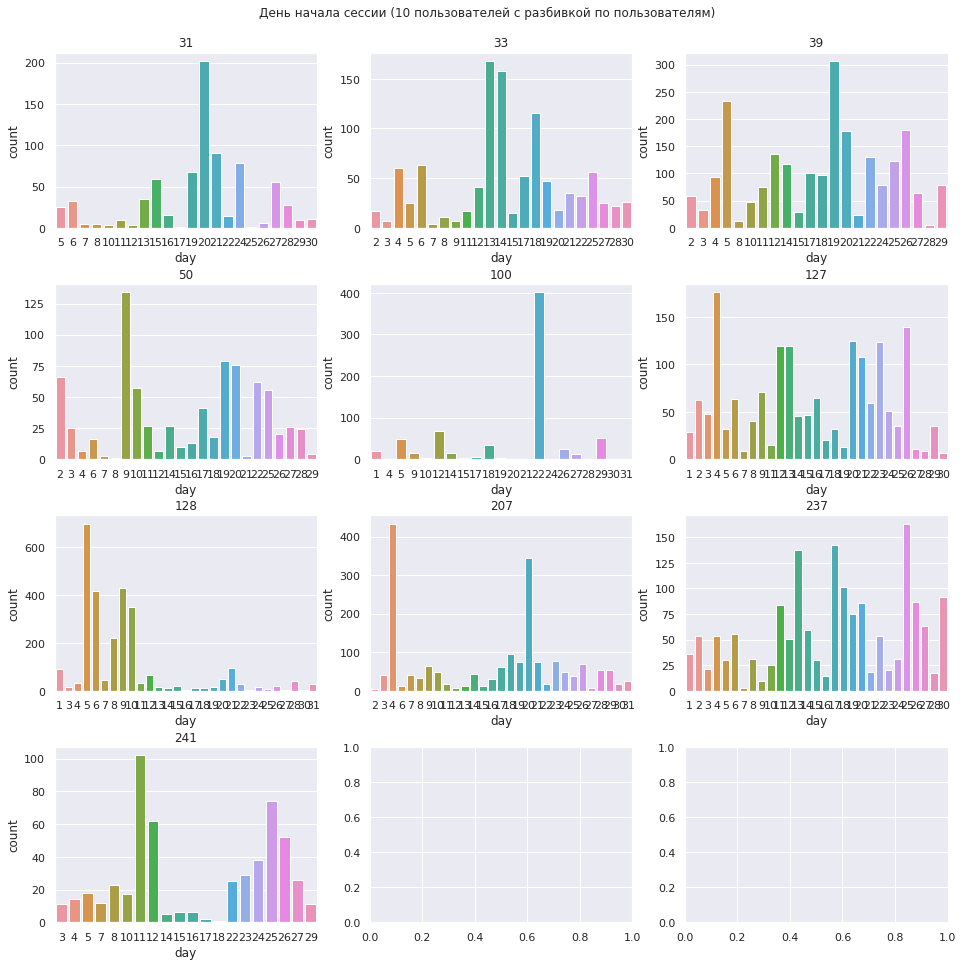

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('День начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.day, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### День недели

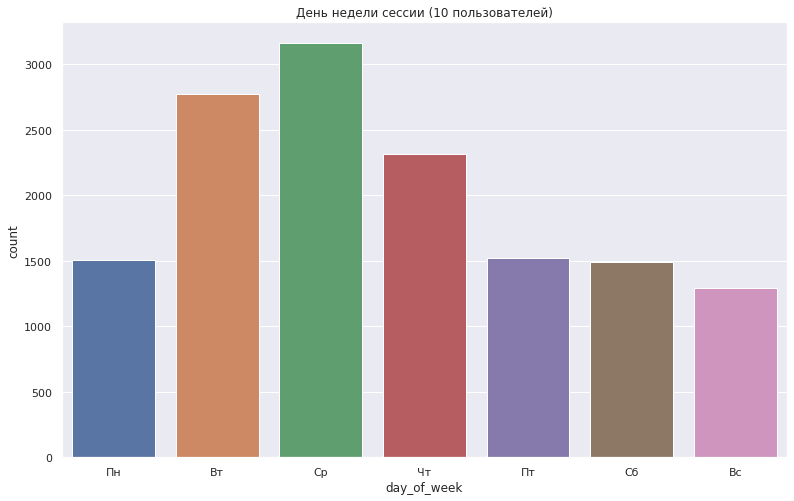

In [101]:
sns.countplot(train_data_10users.day_of_week)
plt.title('День недели сессии (10 пользователей)');
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

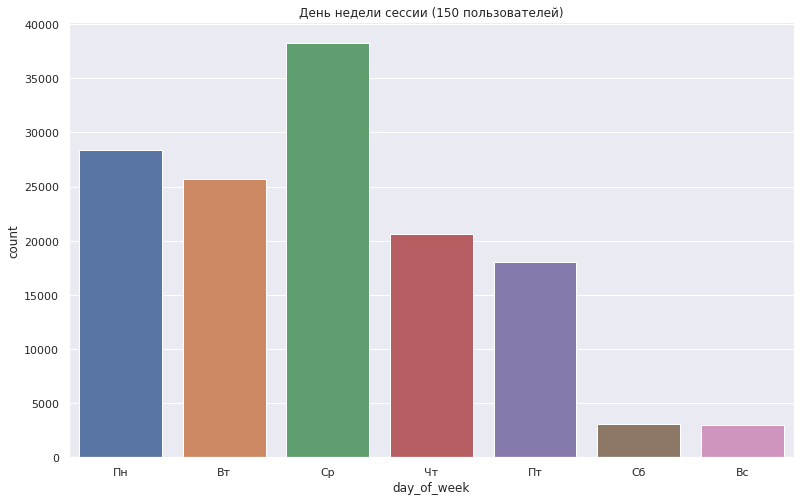

In [102]:
sns.countplot(train_data_150users.day_of_week)
plt.title('День недели сессии (150 пользователей)');
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

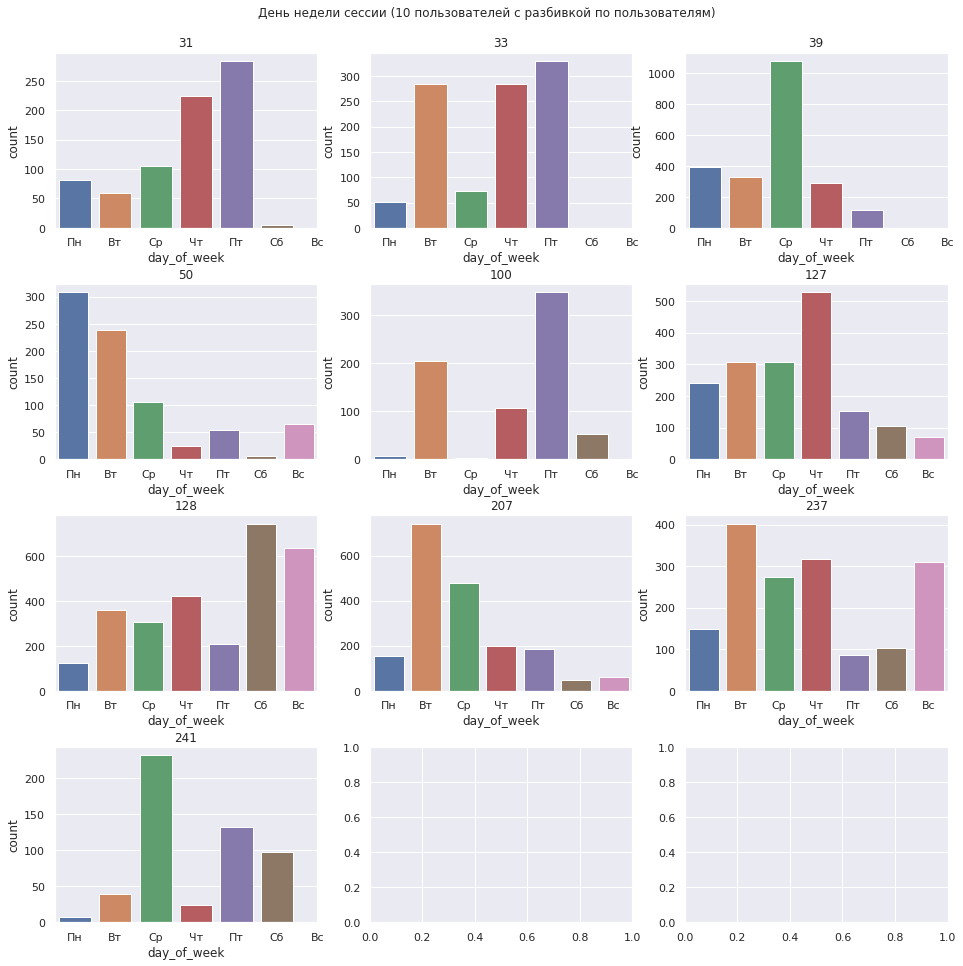

In [113]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('День недели сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.day_of_week, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)
    axes[idx//3, idx%3].set_xticks(range(7))
    axes[idx//3, idx%3].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

##### Час начала сессии

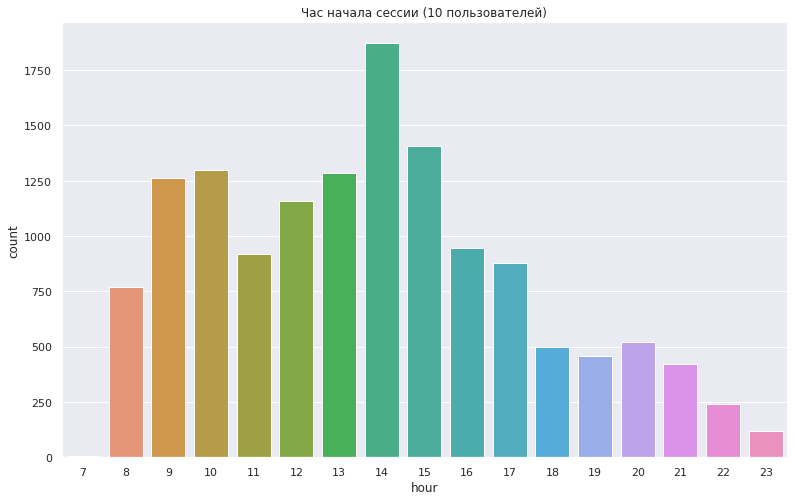

In [58]:
sns.countplot(train_data_10users.hour)
plt.title('Час начала сессии (10 пользователей)');

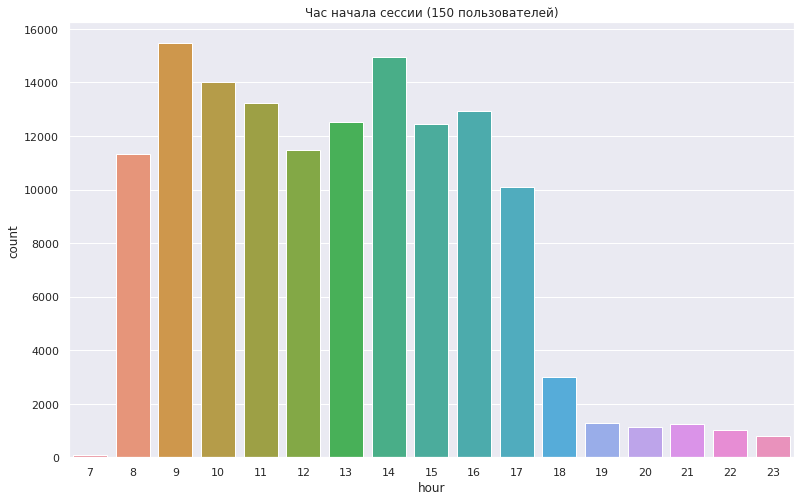

In [59]:
sns.countplot(train_data_150users.hour)
plt.title('Час начала сессии (150 пользователей)');

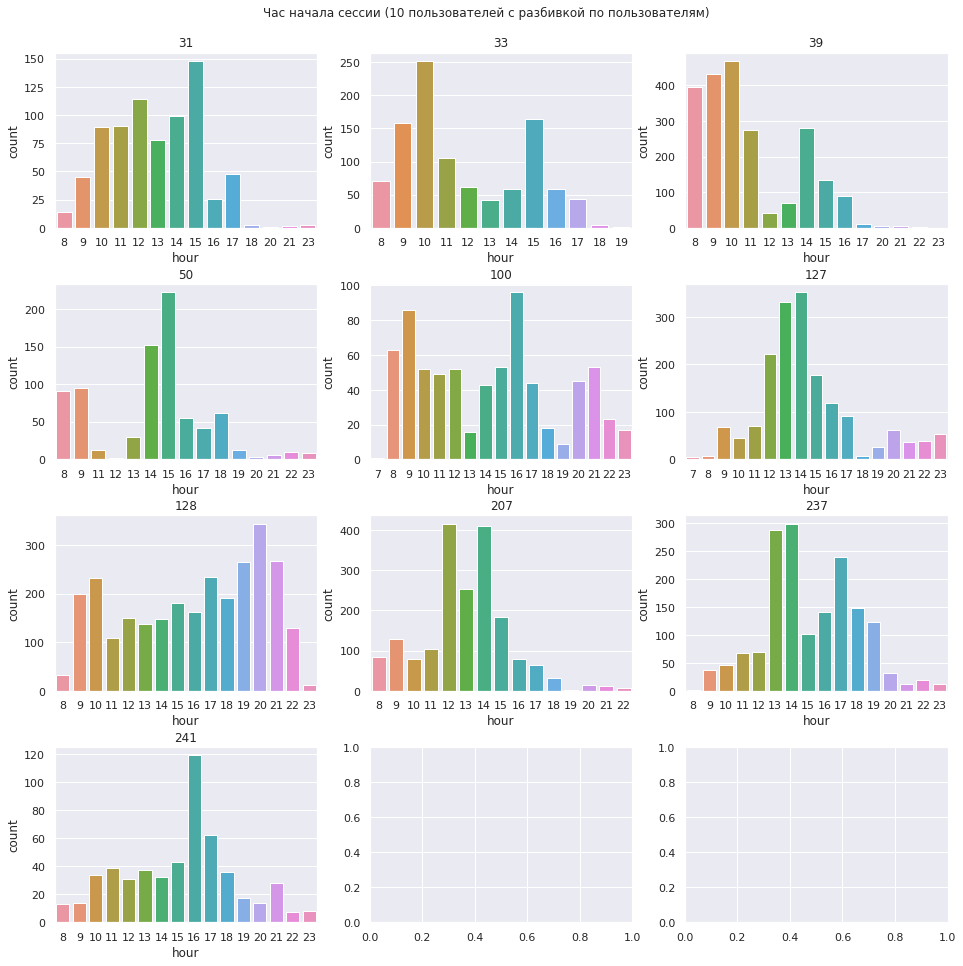

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Час начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.hour, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Минуты

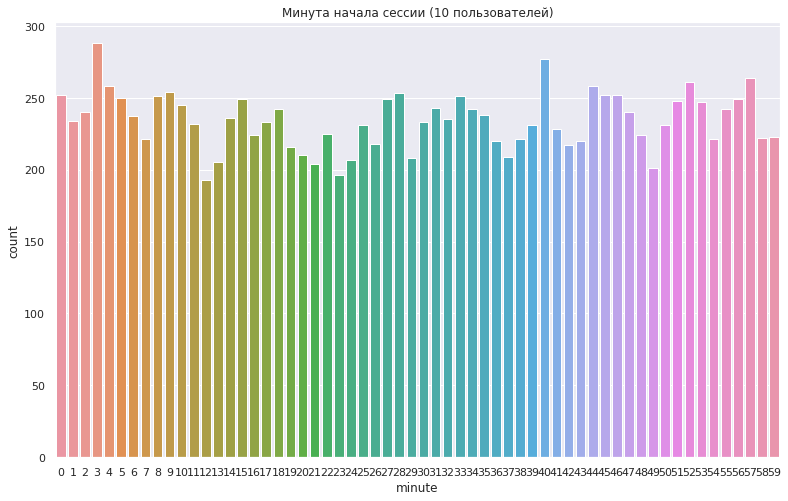

In [62]:
sns.countplot(train_data_10users.minute)
plt.title('Минута начала сессии (10 пользователей)');

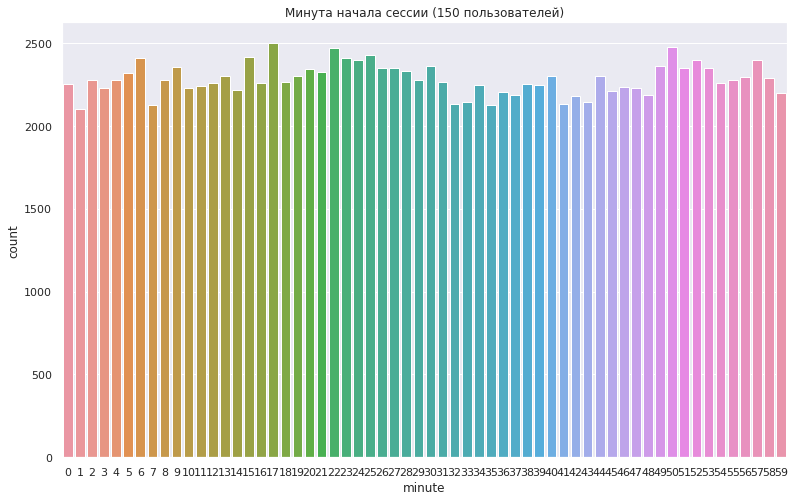

In [63]:
sns.countplot(train_data_150users.minute)
plt.title('Минута начала сессии (150 пользователей)');

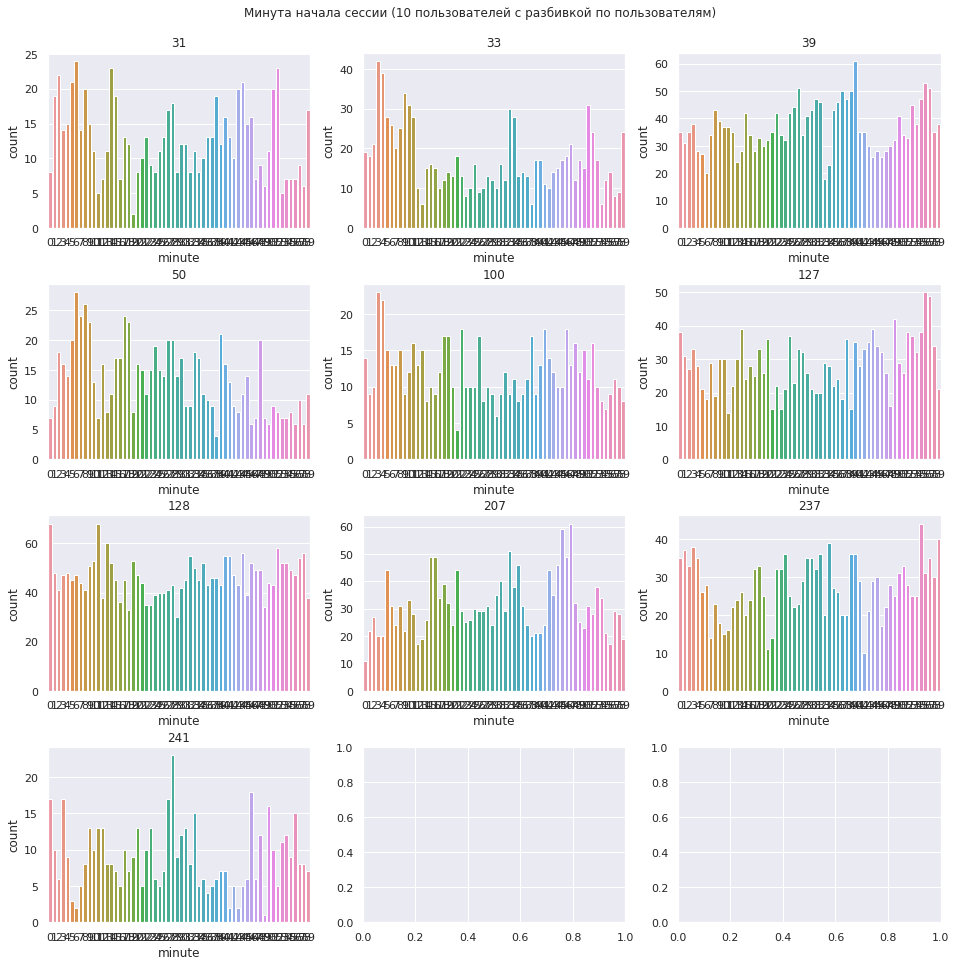

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Минута начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.minute, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Секунды

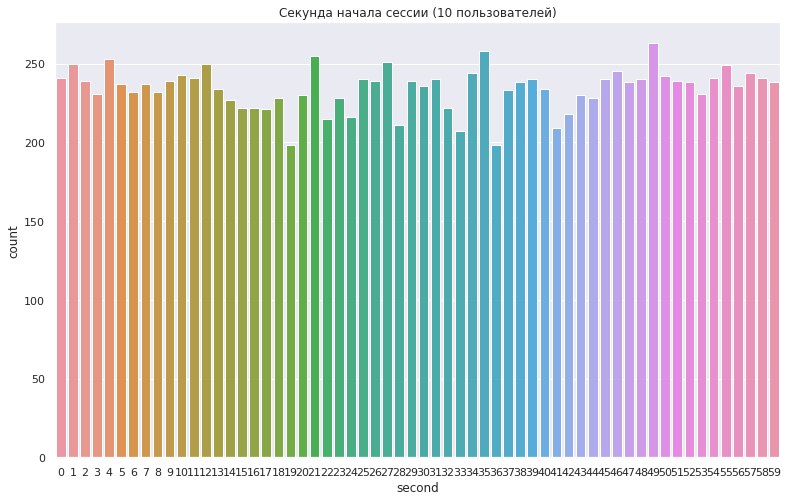

In [65]:
sns.countplot(train_data_10users.second)
plt.title('Секунда начала сессии (10 пользователей)');

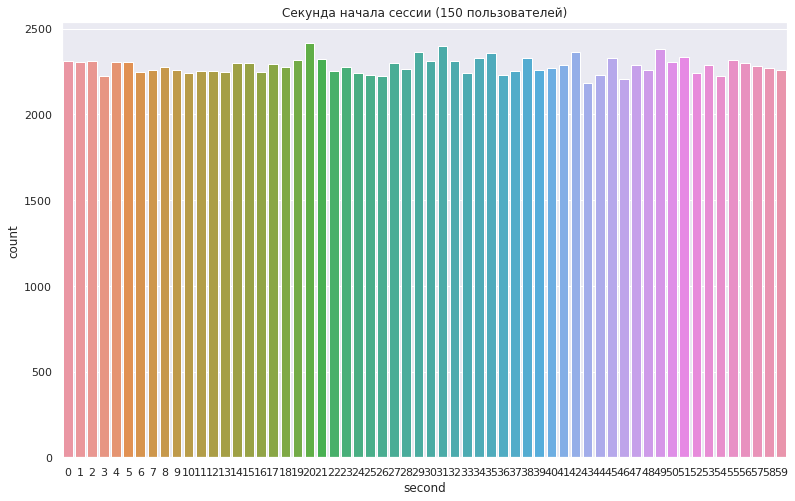

In [66]:
sns.countplot(train_data_150users.second)
plt.title('Секунда начала сессии (150 пользователей)');

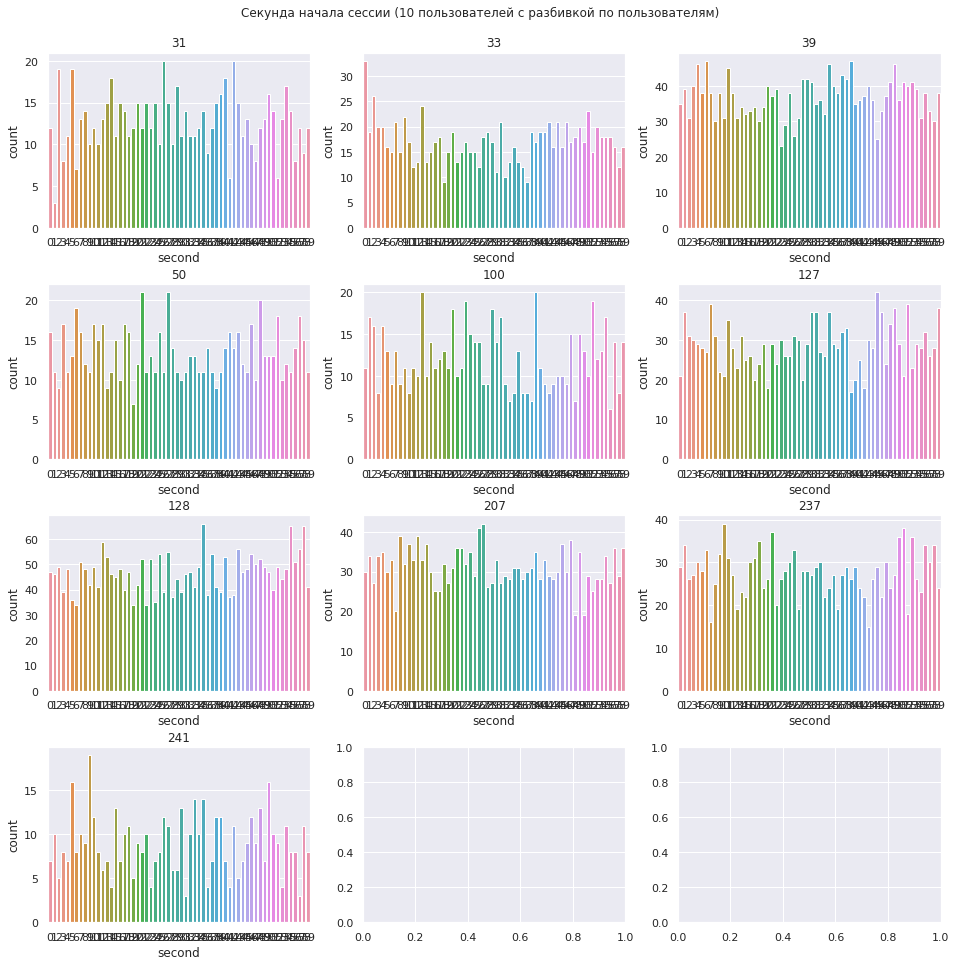

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Секунда начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.second, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Час+минуты

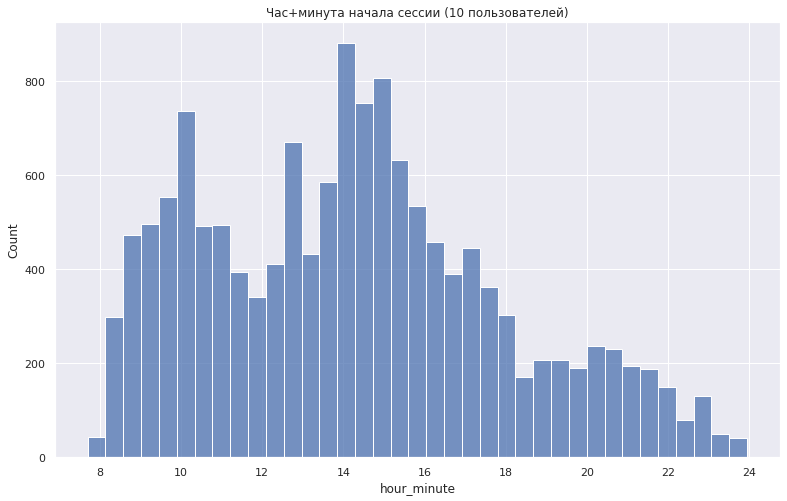

In [69]:
sns.histplot(train_data_10users.hour_minute)
plt.title('Час+минута начала сессии (10 пользователей)');

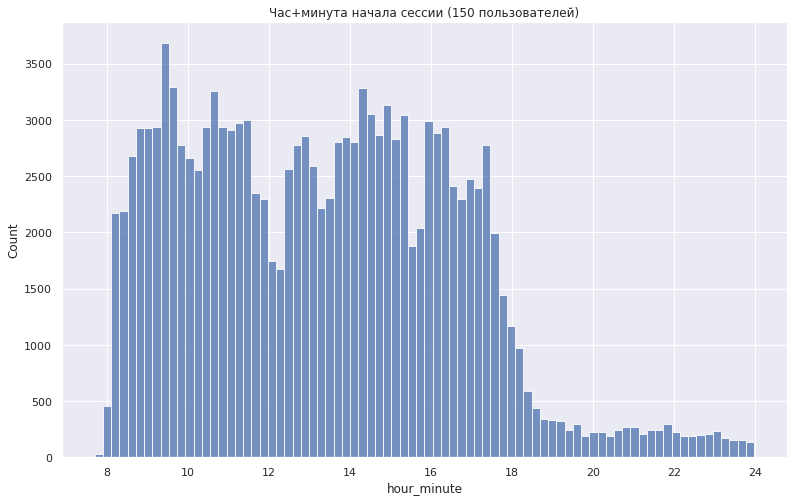

In [70]:
sns.histplot(train_data_150users.hour_minute)
plt.title('Час+минута начала сессии (150 пользователей)');

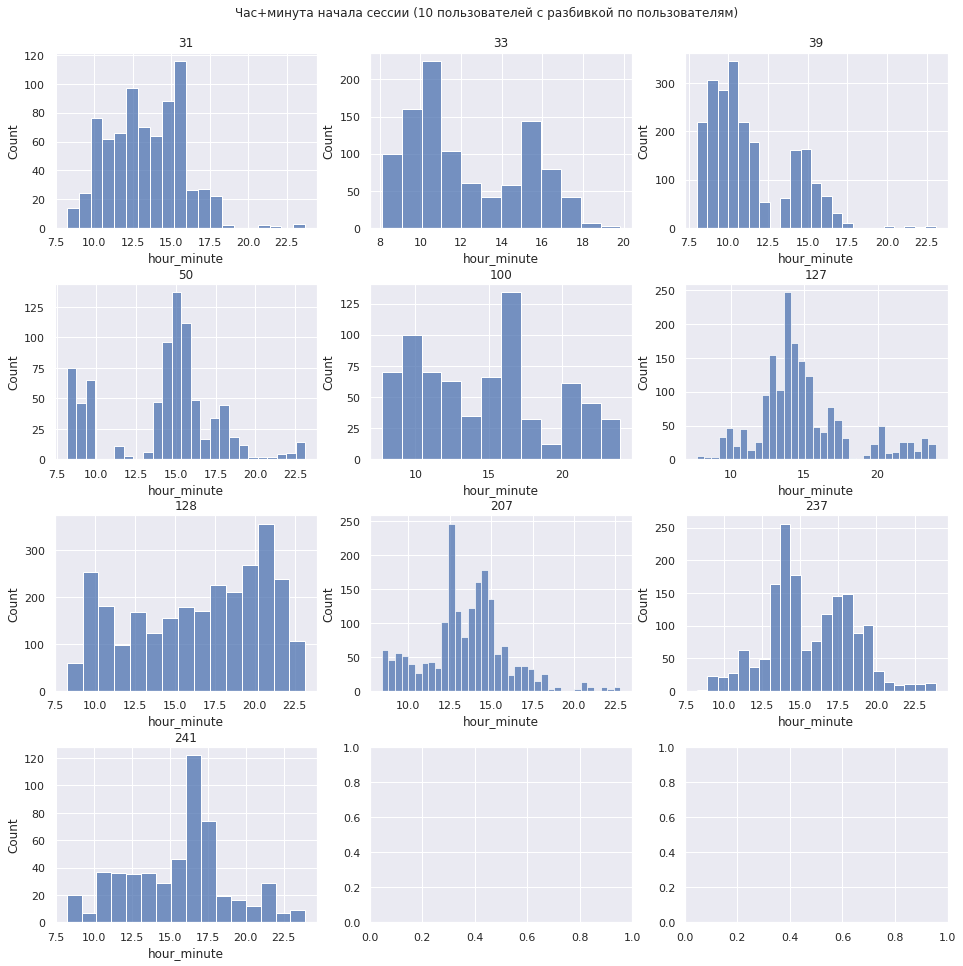

In [71]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Час+минута начала сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.histplot(sub_df.hour_minute, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Среднее время посещения сайта

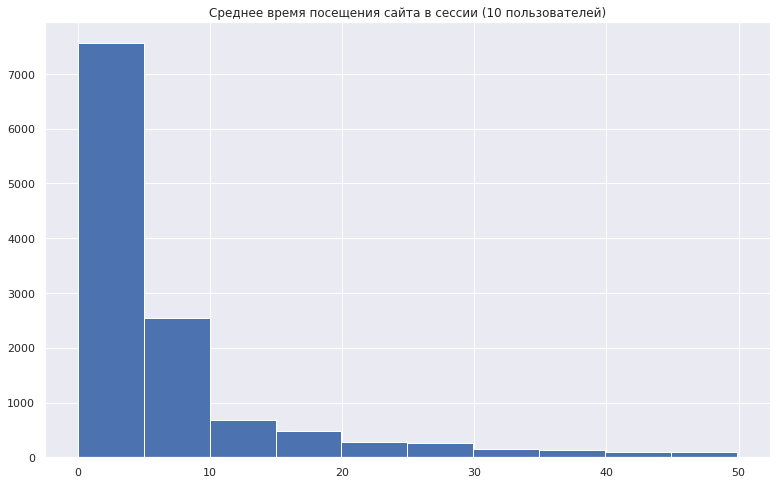

In [96]:
train_data_10users[train_data_10users.visit_mean_time < 50].visit_mean_time.hist()
plt.title('Среднее время посещения сайта в сессии (10 пользователей)');

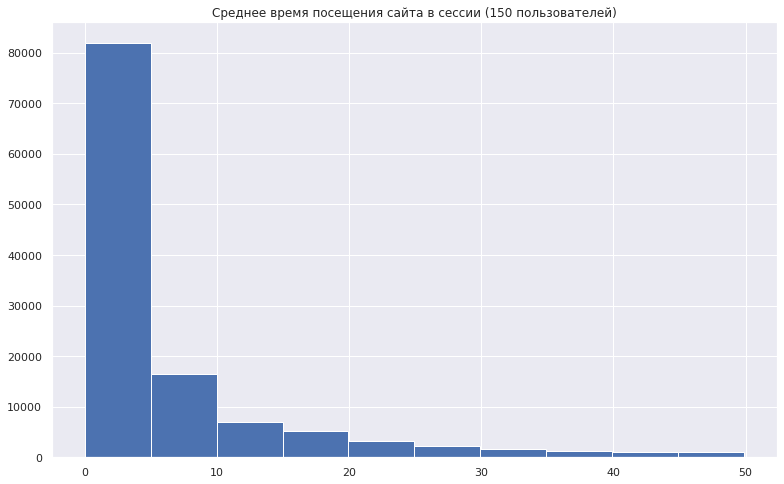

In [97]:
train_data_150users[train_data_150users.visit_mean_time < 50].visit_mean_time.hist()
plt.title('Среднее время посещения сайта в сессии (150 пользователей)');

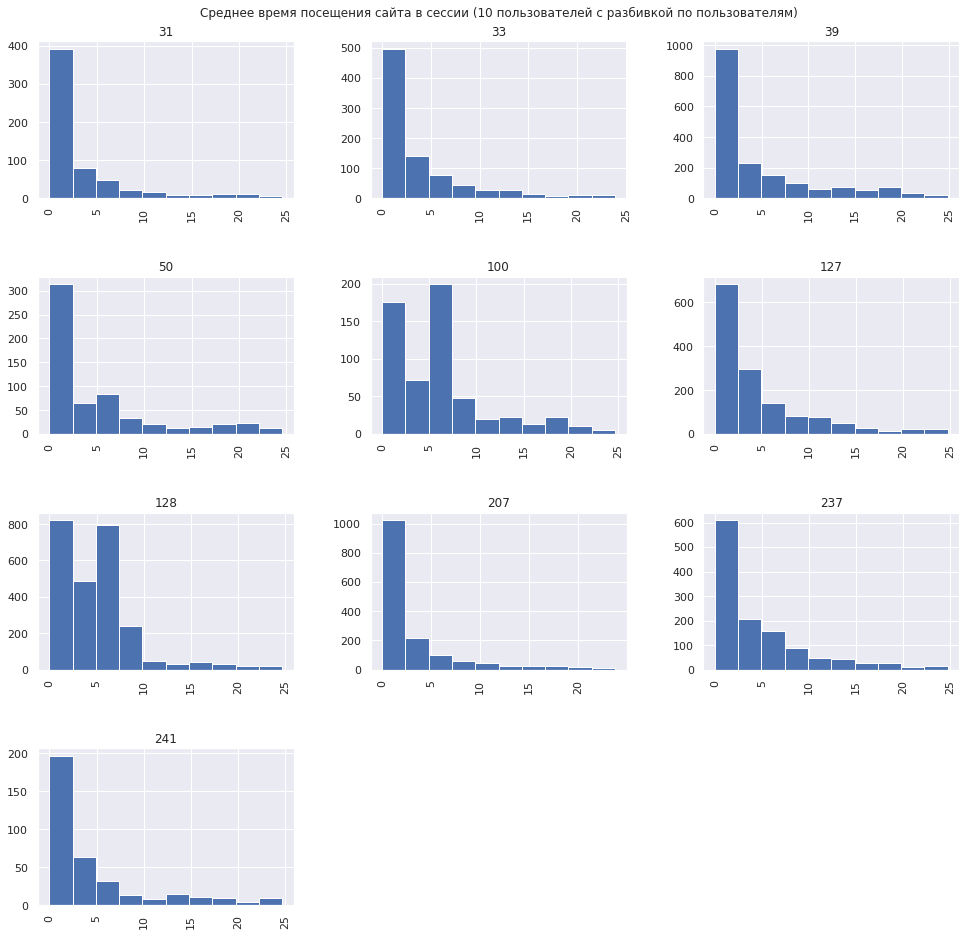

In [80]:
train_data_10users[train_data_10users.visit_mean_time < 25].hist('visit_mean_time', by='user_id', figsize=(16, 16));
# ограничение для убирания длинного правого хвоста
plt.suptitle('Среднее время посещения сайта в сессии (10 пользователей с разбивкой по пользователям)', y=0.93);

##### Продолжительность сессии

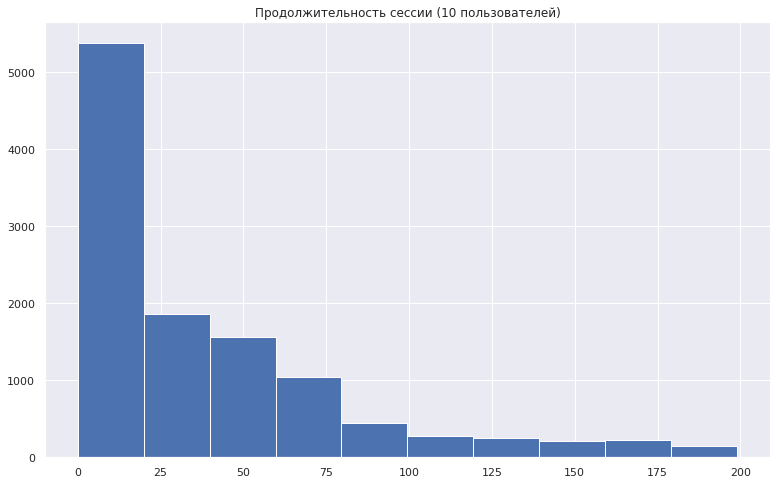

In [90]:
train_data_10users[train_data_10users.session_timespan < 200].session_timespan.hist()
plt.title('Продолжительность сессии (10 пользователей)');

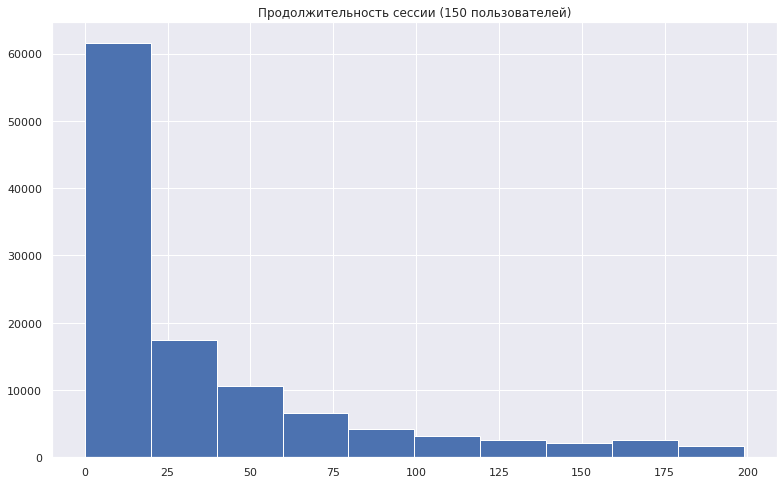

In [91]:
train_data_150users[train_data_150users.session_timespan < 200].session_timespan.hist()
plt.title('Продолжительность сессии (150 пользователей)');

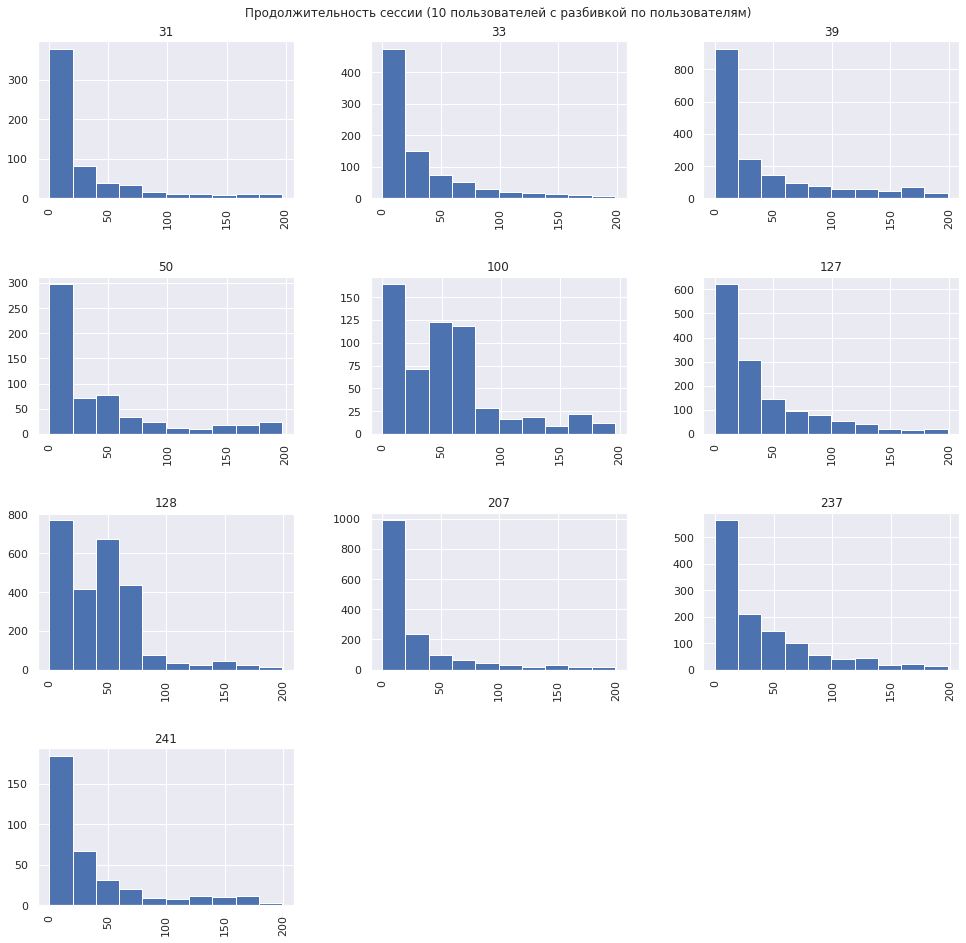

In [92]:
train_data_10users[train_data_10users.session_timespan < 200].hist('session_timespan', by='user_id', figsize=(16, 16));
# ограничение для убирания длинного правого хвоста
plt.suptitle('Продолжительность сессии (10 пользователей с разбивкой по пользователям)', y=0.93);

##### Топ-10 сайтов

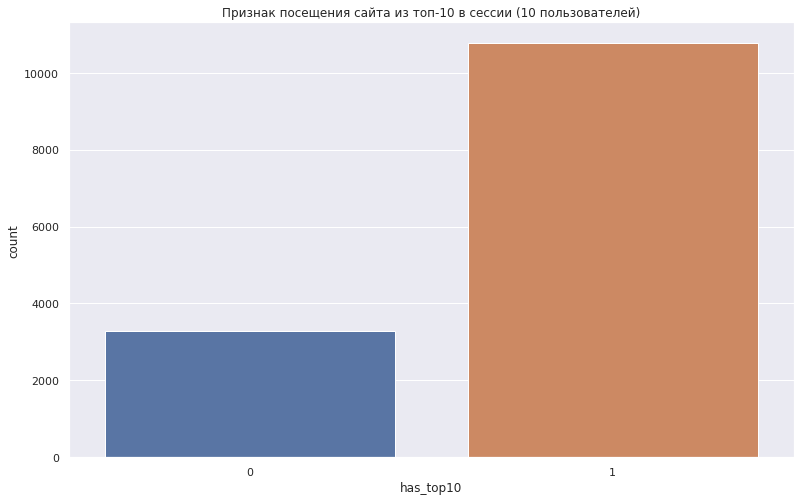

In [84]:
sns.countplot(train_data_10users.has_top10);
plt.title('Признак посещения сайта из топ-10 в сессии (10 пользователей)');

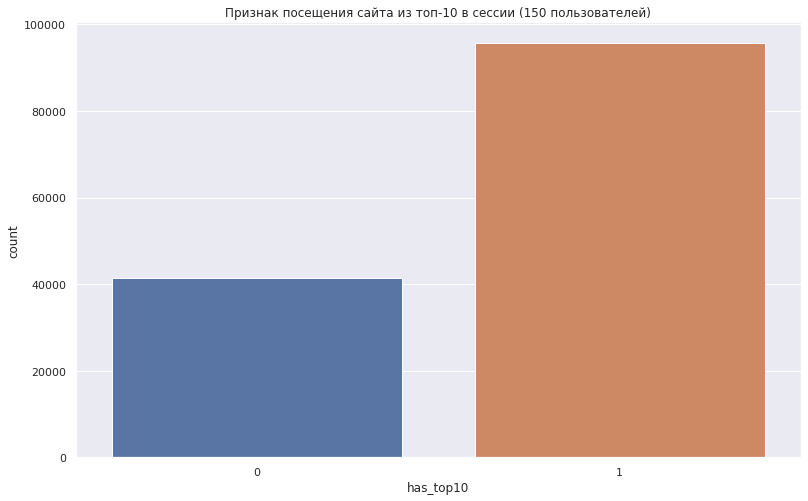

In [85]:
sns.countplot(train_data_150users.has_top10);
plt.title('Признак посещения сайта из топ-10 в сессии (150 пользователей)');

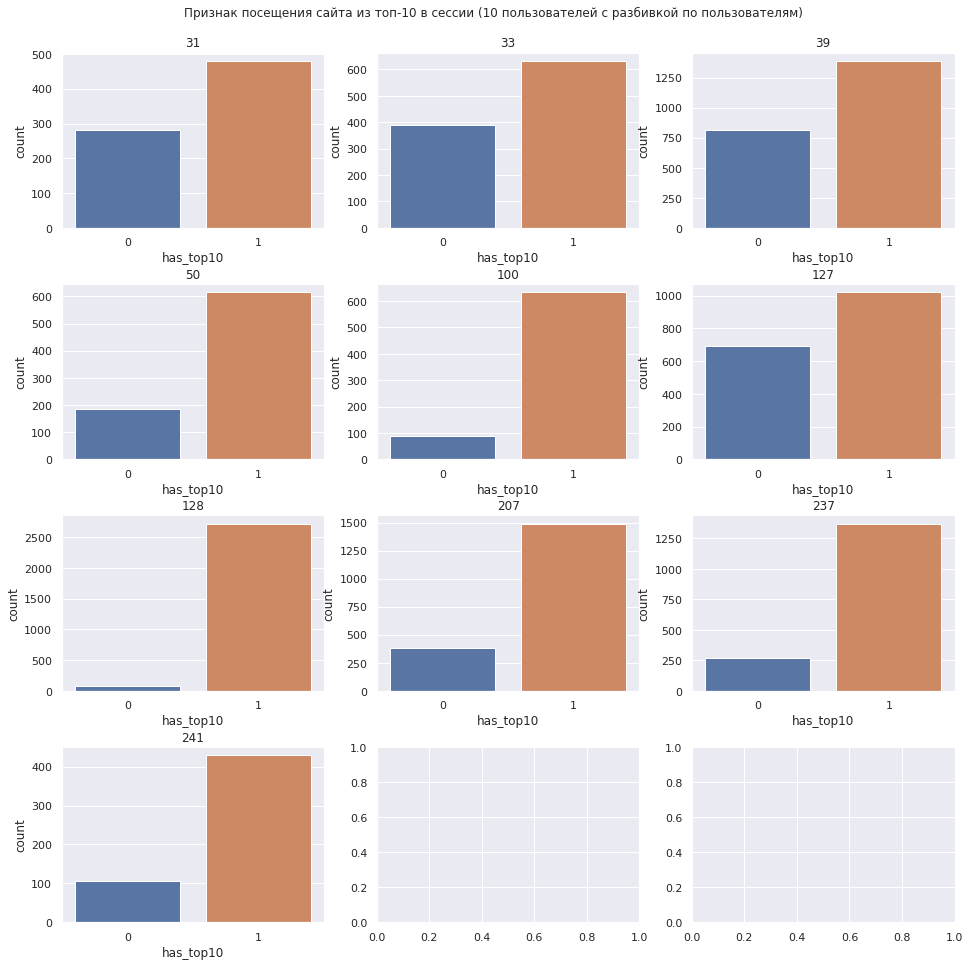

In [86]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Признак посещения сайта из топ-10 в сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.has_top10, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Уникальные сайты

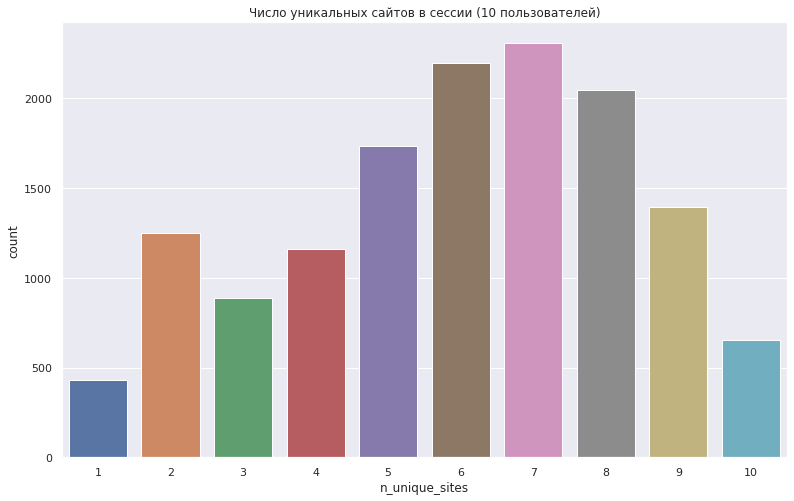

In [87]:
sns.countplot(train_data_10users.n_unique_sites);
plt.title('Число уникальных сайтов в сессии (10 пользователей)');

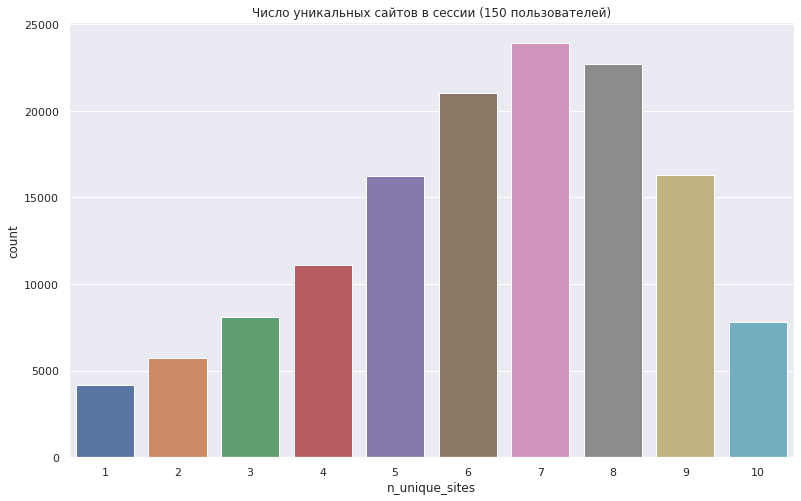

In [88]:
sns.countplot(train_data_150users.n_unique_sites);
plt.title('Число уникальных сайтов в сессии (150 пользователей)');

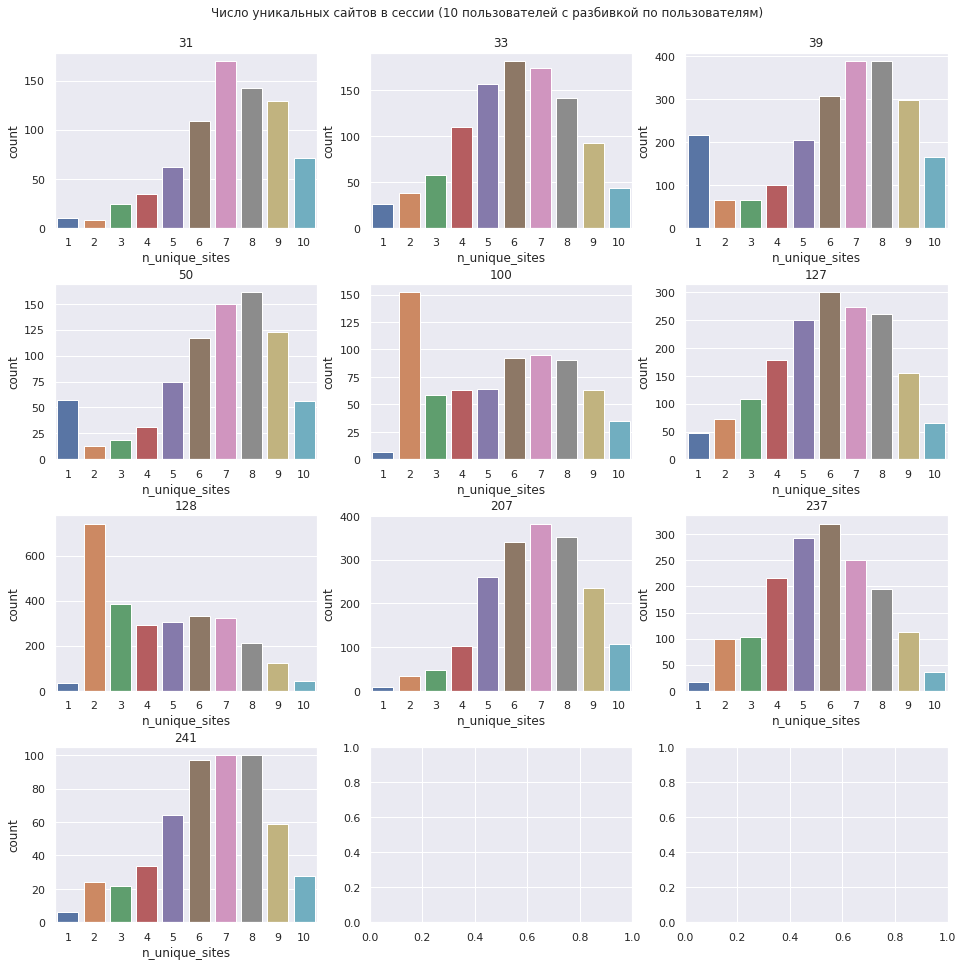

In [89]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
plt.subplots_adjust(hspace=0.32)
fig.suptitle('Число уникальных сайтов в сессии (10 пользователей с разбивкой по пользователям)', y=0.92)

for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_id')):
    sns.countplot(sub_df.n_unique_sites, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(user)

##### Выводы по созданным признакам

|Признак|Особенности|Имеются пользователи с различными распределениями|
|----|----|---|
|Год начала сессии|Большинство сессий зафиксированы в 2014 году|Да|
|Месяц|Январь - май, ноябрь, декабрь; С июня по октябрь сессий не зафиксировано|Да|
|Год+месяц|Конец 2013 (ноябрь, декабрь), начало 2014 (январь - май)|Да|
|День|2-модальное распределение с пиками 5 и 19, 20 числах|Да|
|День недели|Большинство сессий в будние дни|Да|
|Час|Сессии с 8 до 23; Основная часть до 17|Да|
|Минута|Распределение равномерное, закономерностей нет|Нет|
|Секунда|Распределение равномерное, закономерностей нет|Нет|
|Час+минуты|Рисунок в целом повторяет признак Час|Да|
|Среднее время посещения сайта, Продолжительность сессии|Большинство имеет минимальные значения с выбросами с большими значениями|Нет|
|Топ-10 сайтов|Большинство сессий включают сайты из топ-10|Нет|
|Уникальные сайты|Мода - 7. Распределение скошено слева|Есть пользователи с модами 1,2|

#### Предположения об особенностях пользователей

Посмотрим на 10 пользователей, проанализируем несколько их признаков и попробуем сделать предположения о характере использования интернета.

Для наглядности дадим пользователям имена

In [118]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_name'] = train_data_10users['user_id'].map(id_name_dict)
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

##### Число уникальных сайтов

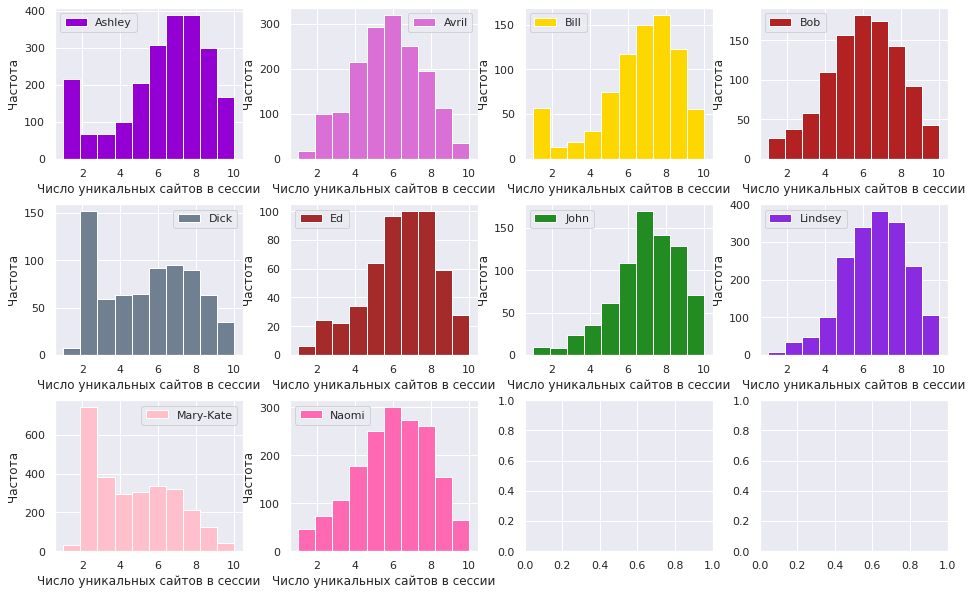

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3, wspace=0.25)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_name')):
    axes[idx//4, idx%4].hist(sub_df['n_unique_sites'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов в сессии')
    axes[idx//4, idx%4].set_ylabel('Частота')

##### Час

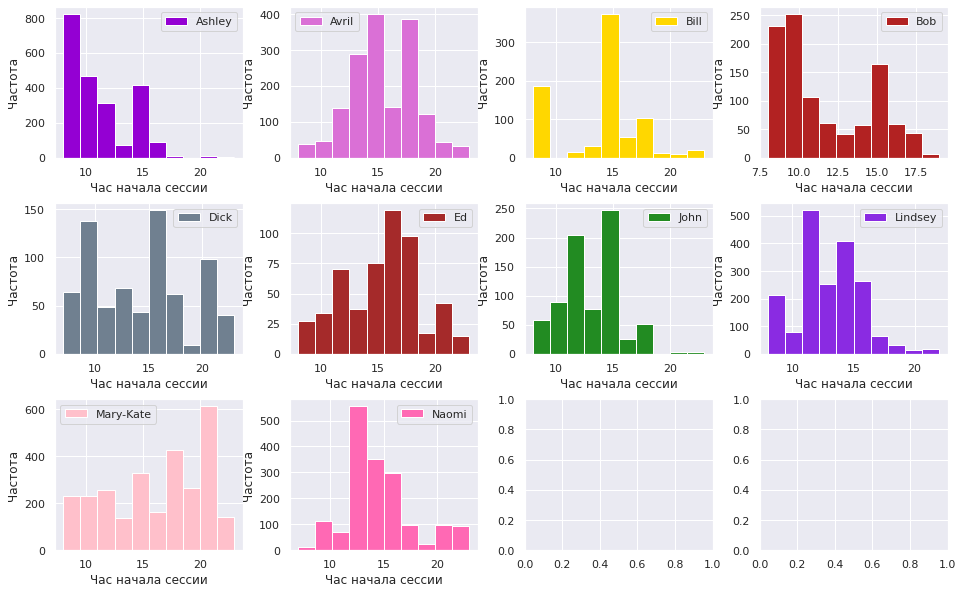

In [122]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plt.subplots_adjust(hspace=0.3, wspace=0.25)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_name')):
    axes[idx//4, idx%4].hist(sub_df['hour'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Час начала сессии')
    axes[idx//4, idx%4].set_ylabel('Частота')

##### День недели

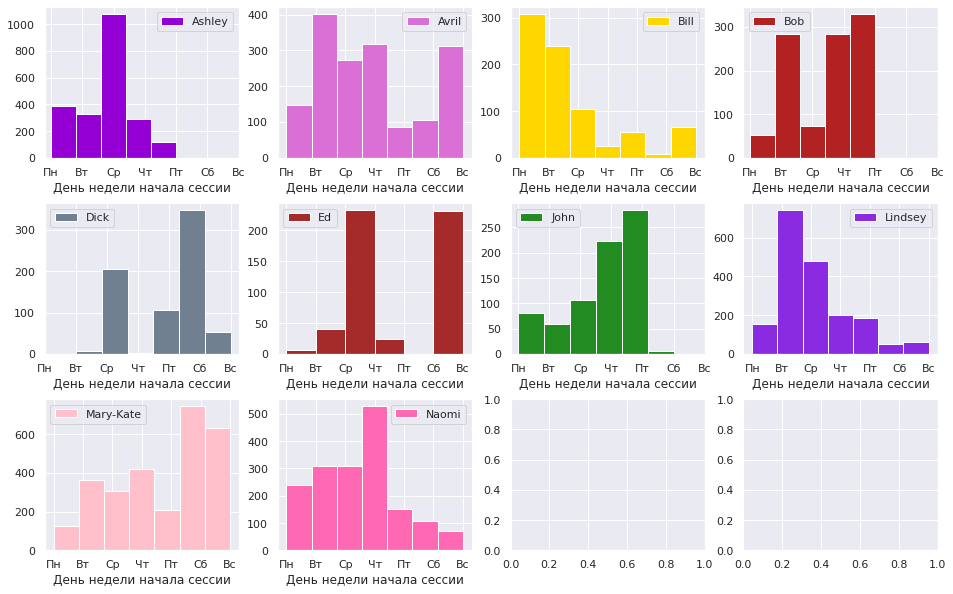

In [123]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='user_name')):
    axes[idx//4, idx%4].hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins=sub_df['day_of_week'].nunique())
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('День недели начала сессии')
    axes[idx//4, idx%4].set_xticks([0, 1, 2, 3, 4, 5, 6])
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

##### Выводы по пользователям

||Ashley|Avril|Bill|Bob|Dick|
|-|-|-|-|-|-|
|Посещение уникальных сайтов|Посещает в среднем 7 сайтов за сессию; также есть сессии с одним уникальным сайтом - пребывание на одном сайте|Распредение ~нормальное вокруг 6|Профиль похож на пользователя Ashley|Распредение ~нормальное вокруг 6|Мода - 2, распределение более равномерное|
|Время начала сессии|Начало сессии в основном приходится на утро; также большое количество сессий начинается около 15 (вероятно послеобеденное время), перед этим "яма"|Большинство сессий начинаются в середине дня|Начало сессий в основном приходится на 9 и 15 часов|Начало сессий в основном приходится на утро и 15 часов|Сесии начинаются в основном в 9, 15, 20 часов|
|День недели начала сессии|Сессии начинаются в будние дни, по выходным сессий нет|Сессии +- равномерно распределены по дням недели; пт, сб - "яма"|Сессии в основном начинаются в рабочие дни + вск|Сессии только по будним дням|Сессии чаще по средам и субботам|
|Возможное объяснение|Можно предположить что сессии связаны с рабочими задачами|Профиль ничем не примечателен|Можно предположить что сессии чаще связаны с рабочими задачами|Предположение: сессии связаны с рабочими задачами|Активное использование в течение дня, но чаще 2 дня в неделю; возможно рабочее использование интернета, но работа с особым графиком|

||Ed|John|Lindsey|Mary-Kate|Naomi|
|-|-|-|-|-|-|
|Посещение уникальных сайтов|Распредение ~нормальное вокруг 7|Распредение скошено вправо; в сессиях преобладают различные сайты|Аналогично пользователю John|Аналогично пользователю Dick|Распредение ~нормальное вокруг 6|
|Время начала сессии|Распредение похоже на нормальное вокруг 16 часов|Рабочее время с всплесками в 12 и 15 часов|Аналогично пользователю John|Количество сессий растёт к концу дня|Мода = 12|
|День недели начала сессии|В основном среда и выходные|Рабочие дни|В основном рабочие дни|Будние дни, но чаще в выходные|Будние дни|
|Возможное объяснение|График использования по дням похож на полдьзователя Dick|Рабочие задачи, вероятно, поиск информации на разных сайтах|В основном рабочие дни,есть, но меньше посещений в выходные|Можно предположить что использование интернеты связано в основном с личными делами|Рабочие задачи, но рабочий день начинается позже|

## Обучение моделей

In [91]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (13, 8)
import warnings
warnings.filterwarnings('ignore')

PATH_TO_DATA = 'data'

### Сравнение моделей

Сравним различные модели на сессиях 10 пользователей (10 сайтов, шаг 10)

Загрузим ранее сохранённые данные

In [5]:
X_sparse_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'sparse_features',  'X_sparse_10users.pkl'))
y_10users  = pd.read_pickle(os.path.join(PATH_TO_DATA, 'sparse_features',  'y_10users.pkl'))

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV)

In [11]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

#### KNeighborsClassifier

In [14]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=1, n_neighbors=100)

Доля верных ответов на кросс-валидации:

In [18]:
knn_score_cv = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
print('Доли верных ответов на кросс-валидации:', knn_score_cv)
print('Средняя доля верных ответов на кросс-валидации:', knn_score_cv.mean())

Доли верных ответов на кросс-валидации: [0.56598598 0.55409936 0.55792683]
Средняя доля верных ответов на кросс-валидации: 0.5593373897012363


Доля верных ответов на отложенной выборке:

In [19]:
knn_score_val = knn.score(X_valid, y_valid)
knn_score_val

0.584024650391088

#### RandomForestClassifier

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

Доля верных ответов при Out-of-Bag оценке:

In [22]:
rf_score_cv = forest.oob_score_
rf_score_cv

0.7225157488315384

Доля верных ответов на отложенной выборке:

In [23]:
rf_score_val = forest.score(X_valid, y_valid)
rf_score_val

0.7350082958046931

#### LogisticRegression

In [25]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=17)

Доля верных ответов на кросс-валидации:

In [26]:
logit_score_cv = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print('Доли верных ответов на кросс-валидации:', logit_score_cv)
print('Средняя доля верных ответов на кросс-валидации:', logit_score_cv.mean())

Доли верных ответов на кросс-валидации: [0.76104846 0.74824749 0.77256098]
Средняя доля верных ответов на кросс-валидации: 0.7606189739891912


Доля верных ответов на отложенной выборке:

In [27]:
logit_score_val = logit.score(X_valid, y_valid)
logit_score_val

0.7767243422611994

Подберём гиперпараметр С (обратный к силе регуляризации) в диапазоне 10 значений от 1e-4 до 1e2

In [32]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 8.42 s, sys: 100 ms, total: 8.52 s
Wall time: 8.29 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C:

In [33]:
logit_mean_cv_scores1 = list(logit_grid_searcher1.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76112701, 0.75868873, 0.74984891, 0.74019648])

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C:

In [36]:
print('Лучшее значение доли правильных ответов на кросс-валидации:', logit_mean_cv_scores1.max())
print('Соответствующее значение C:', logit_grid_searcher1.C_[0])

Лучшее значение доли правильных ответов на кросс-валидации: 0.7611270111481975
Соответствующее значение C: 1.0


График зависимости доли правильных ответов на кросс-валидации от C

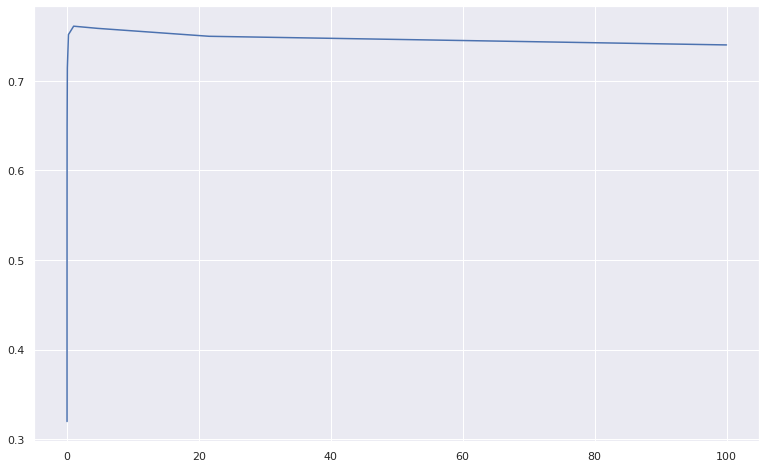

In [41]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

Сузим диапазон подбора и подберём гиперпараметр С (обратный к силе регуляризации) в диапазоне 20 значений от 0.1 до 7

In [42]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 8.1 s, sys: 674 ms, total: 8.77 s
Wall time: 22 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров C

In [43]:
logit_mean_cv_scores2 = list(logit_grid_searcher2.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75919655, 0.76122861, 0.7607206 , 0.76122861,
       0.76153352, 0.76000937, 0.75950134, 0.75980615, 0.75929821,
       0.75909502, 0.75858698, 0.75777422, 0.75726624, 0.75706302,
       0.75625017, 0.75543744, 0.7549294 , 0.75411661, 0.75350695])

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C:

In [44]:
print('Лучшее значение доли правильных ответов на кросс-валидации:', logit_mean_cv_scores2.max())
print('Соответствующее значение C:', logit_grid_searcher2.C_[0])

Лучшее значение доли правильных ответов на кросс-валидации: 0.761533515213238
Соответствующее значение C: 1.9157894736842107


График зависимости доли правильных ответов на кросс-валидации от C

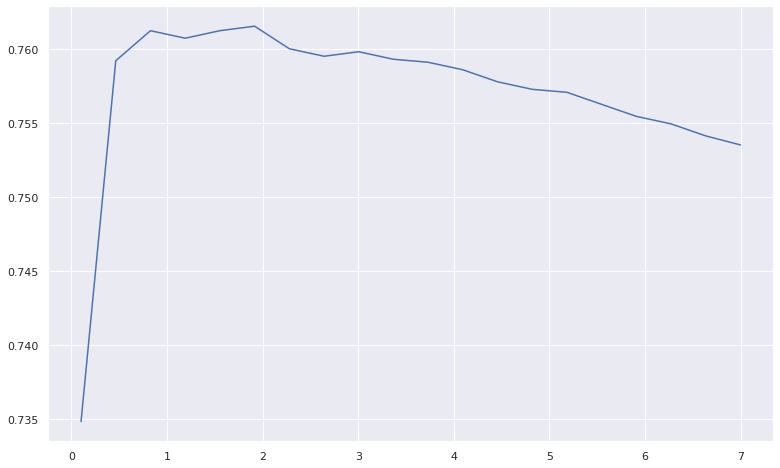

In [45]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Доля верных ответов на отложенной выборке с лучшим найденным значением C

In [46]:
logit_cv_acc = logit_grid_searcher2.score(X_valid, y_valid)
logit_cv_acc

0.7798056411471913

Обучим логистическую регрессию с лучшим значением С

In [47]:
lr = LogisticRegression(C=logit_grid_searcher2.C_[0], random_state=17, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.9157894736842107, n_jobs=-1, random_state=17)

Доля верных ответов на кросс-валидации с лучшим найденным значением C

In [58]:
lr_score_cv = cross_val_score(lr, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print('Доли верных ответов на кросс-валидации:', lr_score_cv)
print('Средняя доли верных ответов на кросс-валидации:', lr_score_cv.mean())

Доли верных ответов на кросс-валидации: [0.76043889 0.75251448 0.77408537]
Средняя доли верных ответов на кросс-валидации: 0.7623462445764354


Доля верных ответов на отложенной выборке с лучшим найденным значением C:

In [53]:
lr_score_val = lr.score(X_valid, y_valid)
lr_score_val

0.7817018250770325

#### LinearSVC

In [55]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)

LinearSVC(C=1, random_state=17)

Доля верных ответов на кросс-валидации:

In [59]:
svm_score_cv = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
print('Доли верных ответов на кросс-валидации:', svm_score_cv)
print('Средняя доли верных ответов на кросс-валидации:', svm_score_cv.mean())

Доли верных ответов на кросс-валидации: [0.75068577 0.73270344 0.7695122 ]
Средняя доли верных ответов на кросс-валидации: 0.7509671352428245


Доля верных ответов на отложенной выборке:

In [60]:
svm_score_val = svm.score(X_valid, y_valid)
svm_score_val

0.7769613652524295

Подберём параметр C (обратный силе регуляризации) для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4

In [63]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1, cv=skf, scoring='accuracy', return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 587 ms, total: 2.88 s
Wall time: 12.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True, scoring='accuracy')

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C:

In [64]:
print('Лучшее значение доли правильных ответов на кросс-валидации:', svm_grid_searcher1.best_score_)
print('Соответствующее значение C:', svm_grid_searcher1.best_params_['C'])

Лучшее значение доли правильных ответов на кросс-валидации: 0.6959968146237391
Соответствующее значение C: 5555.555600000001


График зависимости доли правильных ответов на кросс-валидации от C:

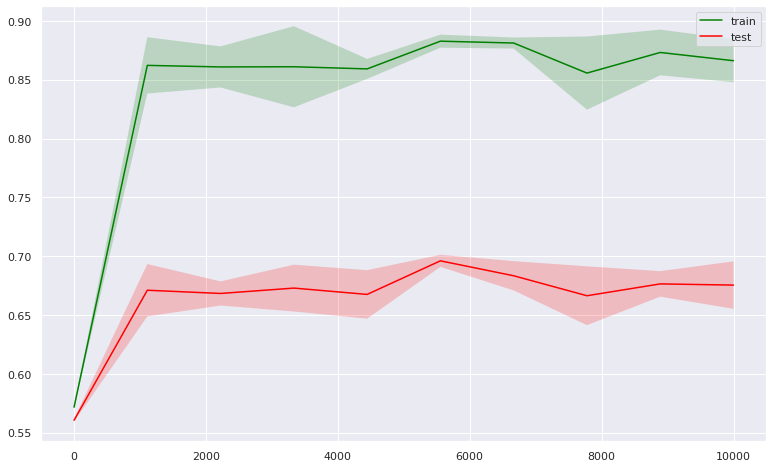

In [65]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

Диапазон подбора гиперпараметра С выбран неверный. Здесь намного осмысленней подбирать C в районе 1, к тому же, так модель быстрее обучается, чем при больших C.

In [66]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, n_jobs=-1, cv=skf, scoring='accuracy', return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 685 ms, sys: 6.72 ms, total: 691 ms
Wall time: 12.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True, scoring='accuracy')

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение C:

In [67]:
print('Лучшее значение доли правильных ответов на кросс-валидации:', svm_grid_searcher2.best_score_)
print('Соответствующее значение C:', svm_grid_searcher2.best_params_['C'])

Лучшее значение доли правильных ответов на кросс-валидации: 0.7670206386611259
Соответствующее значение C: 0.10434482758620689


График зависимости доли правильных ответов на кросс-валидации от C:

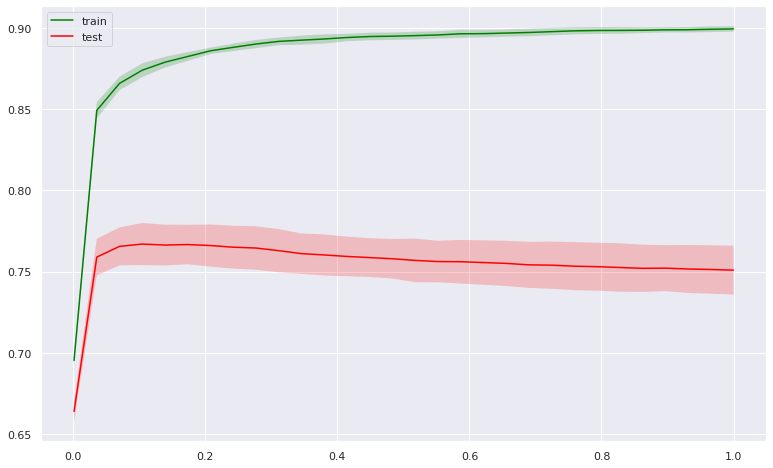

In [68]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Доля правильных ответов на отложенной выборке с лучшим найденным значением C:

In [69]:
svm_grid_searcher2.score(X_valid, y_valid)

0.7807537331121118

Доля правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра C

In [70]:
svm_score_cv = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print('Доли верных ответов на кросс-валидации:', svm_score_cv)
print('Средняя доли верных ответов на кросс-валидации:', svm_score_cv.mean())

Доли верных ответов на кросс-валидации: [0.76409631 0.75281926 0.78414634]
Средняя доли верных ответов на кросс-валидации: 0.7670206386611259


Лучшее значение доли верных ответов на кросс-валидации показал LinearSVC.

### Выбор параметров – длины сессии и размера шага

Возьмем LinearSVC, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров session_length и window_size)

In [71]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
#     from sklearn.exceptions import NotFittedError
    
    X_sparse = pd.read_pickle(path_to_X_pickle)
    y = pd.read_pickle(path_to_y_pickle)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, random_state=random_state, 
                                                          test_size=test_size, stratify=y)
    
    accuracy_cv = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    
    
    estimator.fit(X_train, y_train)
    accuracy_ho = estimator.score(X_valid, y_valid)
#     try:
#         accuracy_ho = estimator.score(X_valid, y_valid)
#     except NotFittedError:

    
    return accuracy_cv.mean(), accuracy_ho

In [72]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'sparse_features', 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

Посчитаем долю верных ответов (на кросс-валидации и на отложенной выборке) для всех возможных сочетаний параметров _размер сессии_ и _размер шага_ для 10 пользователей

In [75]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'y_10users_s{session_length}_w{window_size}.pkl')
        print('Session lenght:', session_length)
        print('Windows size:', window_size)
        print('CV accuracy, holdout accuracy:', model_assessment(
            estimator=estimator,
            path_to_X_pickle=path_to_X_pkl,
            path_to_y_pickle=path_to_y_pkl,
            cv=skf
            )
        )
        print()

Session lenght: 15
Windows size: 10
CV accuracy, holdout accuracy: (0.8243252292702751, 0.8404835269021095)

Session lenght: 10
Windows size: 10
CV accuracy, holdout accuracy: (0.7670206386611259, 0.7807537331121118)

Session lenght: 15
Windows size: 7
CV accuracy, holdout accuracy: (0.8495024256089474, 0.8543222166915547)

Session lenght: 10
Windows size: 7
CV accuracy, holdout accuracy: (0.7983645917156946, 0.8073668491786958)

Session lenght: 7
Windows size: 7
CV accuracy, holdout accuracy: (0.754765400423003, 0.7617388418782147)

Session lenght: 15
Windows size: 5
CV accuracy, holdout accuracy: (0.8670355547005402, 0.8752963489805595)

Session lenght: 10
Windows size: 5
CV accuracy, holdout accuracy: (0.8177520250854086, 0.8245614035087719)

Session lenght: 7
Windows size: 5
CV accuracy, holdout accuracy: (0.772939529035208, 0.7853247984826932)

Session lenght: 5
Windows size: 5
CV accuracy, holdout accuracy: (0.7254849424351582, 0.7362494073020389)

CPU times: user 6.57 s, sys: 31

Качество модели зависит от session_length, window_size следующим образом: чем больше длина сессии и чем меньше шаг (размер окна), тем выше качество: s15_w5.

Доля правильных ответов для LinearSVC с настроенным параметром C и выборки X_sparse_10users_s15_w5

In [77]:
acc_cv_10users_s15_w5, acc_ho_10users_s15_w5 = model_assessment(
    estimator=LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17),
    path_to_X_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_10users_s15_w5.pkl'),
    path_to_y_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'y_10users_s15_w5.pkl'),
    cv=skf
)
print('CV accuracy:', acc_cv_10users_s15_w5)
print('holdout accuracy:', acc_ho_10users_s15_w5)

CV accuracy: 0.8670355547005402
holdout accuracy: 0.8752963489805595


Посчитаем долю верных ответов (на кросс-валидации и на отложенной выборке) для сочетаний параметров _размер сессии_ и _размер шага_ (5,5), (7,7) и (10,10) для 150 пользователей

In [78]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'y_150users_s{session_length}_w{window_size}.pkl')
    print('Session lenght:', session_length)
    print('Windows size:', window_size)
    print('CV accuracy, holdout accuracy:', model_assessment(
        estimator=estimator,
        path_to_X_pickle=path_to_X_pkl,
        path_to_y_pickle=path_to_y_pkl,
        cv=skf
        )
    )
    print()

Session lenght: 5
Windows size: 5
CV accuracy, holdout accuracy: (0.4083611011164474, 0.42171606560568453)

Session lenght: 7
Windows size: 7
CV accuracy, holdout accuracy: (0.4366487102001489, 0.45295840855673264)

Session lenght: 10
Windows size: 10
CV accuracy, holdout accuracy: (0.46307591254574465, 0.4836276942538802)

CPU times: user 5min 53s, sys: 588 ms, total: 5min 54s
Wall time: 10min 22s


Доля правильных ответов для LinearSVC с настроенным параметром C и выборки X_sparse_150users_s10_w10

In [79]:
%%time
acc_cv_150users_s10_w10, acc_ho_150users_s10_w10 = model_assessment(
    estimator=LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17),
    path_to_X_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_150users_s10_w10.pkl'),
    path_to_y_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'y_150users_s10_w10.pkl'),
    cv=skf
)
print('CV accuracy:', acc_cv_150users_s10_w10)
print('holdout accuracy:', acc_ho_150users_s10_w10)

CV accuracy: 0.46307591254574465
holdout accuracy: 0.4836276942538802
CPU times: user 1min 52s, sys: 429 ms, total: 1min 52s
Wall time: 3min 24s


Многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика.

### Идентификация конкретного пользователя и кривые обучения

Попробуем идентифицировать конкретного пользователя на выборке из 150 пользователей. Будем решать 150 задач "Один-против-Всех".

Загрузим датасет по 150 пользователям c параметрами (10, 10)

In [84]:
X_sparse_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_150users_s10_w10.pkl'))
y_150users  = pd.read_pickle(os.path.join(PATH_TO_DATA, 'sparse_features', 'y_150users.pkl'))

In [85]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

Обучим LogisticRegressionCV для одного значения параметра C (лучшего на кросс-валидации logit_grid_searcher2)

In [86]:
%%time
logit_cv_150users_ = LogisticRegressionCV(Cs=[logit_grid_searcher2.C_[0]], multi_class='ovr', 
                                          random_state=17, n_jobs=-1, cv=skf)
logit_cv_150users_.fit(X_train_150, y_train_150)

CPU times: user 20min 1s, sys: 23.8 s, total: 20min 25s
Wall time: 3min 46s


LogisticRegressionCV(Cs=[1.9157894736842107],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности

In [87]:
cv_scores_by_user = {}
i = 0
for user_id, scores in logit_cv_150users_.scores_.items():
    cv_scores_by_user[user_id] = scores.mean()
    if i <= 5:
        print(f'User {user_id}, CV score: {scores.mean()}')
    i += 1

User 6, CV score: 0.9960797806345333
User 13, CV score: 0.9963091551718745
User 15, CV score: 0.995256117523172
User 16, CV score: 0.9918467778090561
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9944011760658097


Результаты очень высокие, однако это достигается засчёт несбалансрованности классов в выборке. Вероятно, высокую долю верных ответов можно получить константным прогнозом. Для каждого пользователя посчитаем разницу между долей правильных ответов на кросс-валидации и долей меток в y_train_150, отличных от ID этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All)

In [88]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id]/len(y_train_150))

num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

127

Доля пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного:

In [89]:
num_better_than_default / 150

0.8466666666666667

Построим кривые обучения для конкретного пользователя, допустим, для 128-го.

Составим новый бинарный вектор на основе y_150users, его значения будут 1 или 0 в зависимости от того, равен ли ID пользователя 128

In [90]:
y_binary_128 = [int(i == 128) for i in y_150users]

In [92]:
def plot_learning_curve(val_train, val_test, train_sizes, xlabel='Training Set Size', ylabel='score'):
    
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
        
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Посчитаем доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки

In [93]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes)

CPU times: user 37.9 s, sys: 49.5 ms, total: 37.9 s
Wall time: 37.9 s


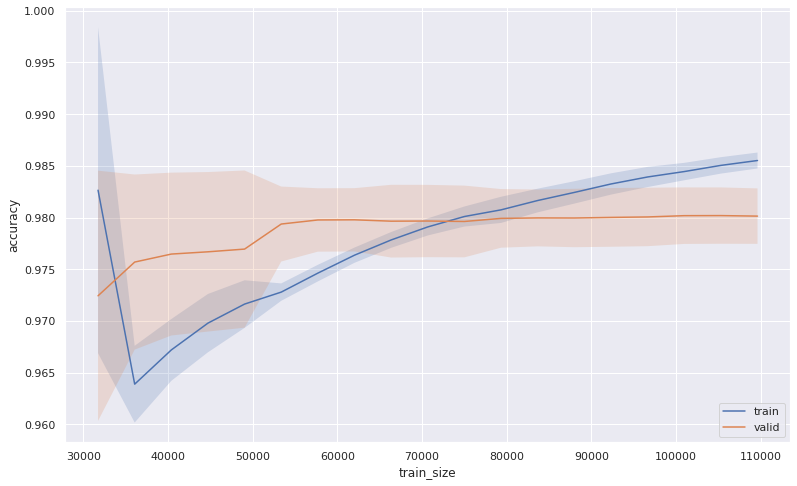

In [94]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

Выводы:

- на обучающей выборке качество очевидно растёт с ростом размера выборки
- на тестовой выборке качество не растёт, начиная с размера ~55000
- новые данные не помогут улучшить качество модели